#NASA CMAPSS - Predictive Maintenance using LSTM
This notebook builds an LSTM-based model to predict Remaining Useful Life (RUL) for aircraft engines using the FD001 subset of the CMAPSS dataset.

✅ Includes:

* Data loading
* RUL computation
* Data preprocessing and normalization
* Baseline Models
* Sequence creation for LSTM
* LSTM model training and evaluation
* Test set prediction
* Feature Engineering (FFT)
* Data Preparation for CNN-LSTM
* Model Building (CNN-LSTM Hybrid)
* Model Training (CNN-LSTM Hybrid)
* Data Preparation for Early-Life Training
* Model Training (Early-Life Cycles)
* Data Preparation for Midpoint-Cycle Training
* Model Training (Midpoint-Cycles)
* Evaluation and Warning Time Analysis
* Conclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore

In [2]:
train_df = pd.read_csv('train_FD001.txt')
train_df.head()

1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.30 47.47 521.66 2388.02 8138.62 8.4195 0.03 392 2388 100.00 39.06 23.4190  
0  1 2 0.0019 -0.0003 100.0 518.67 642.15 1591.82...                                                                                                                      
1  1 3 -0.0043 0.0003 100.0 518.67 642.35 1587.99...                                                                                                                      
2  1 4 0.0007 0.0000 100.0 518.67 642.35 1582.79 ...                                                                                                                      
3  1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.8...                                                                                                                      
4  1 6 -0.0043 -0.0001 100.0 518.67 642.10 1584.4...

In [3]:
# The FD001 dataset has 26 columns:
# 1: engine_id
# 2: cycle
# 3: setting1 (operational setting 1)
# 4: setting2 (operational setting 2)
# 5: setting3 (operational setting 3)
# 6-26: sensor_1 to sensor_21

column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3',
                'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
                'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10',
                'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
                'sensor21']

# Load the training data
train_df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)

# Load the test data (without RUL)
test_df = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)

# Load the RUL data for the test set
rul_df = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("RUL data shape:", rul_df.shape)

Training data shape: (20631, 26)
Test data shape: (13096, 26)
RUL data shape: (100, 1)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   engine_id  20631 non-null  int64  
 1   cycle      20631 non-null  int64  
 2   setting1   20631 non-null  float64
 3   setting2   20631 non-null  float64
 4   setting3   20631 non-null  float64
 5   sensor1    20631 non-null  float64
 6   sensor2    20631 non-null  float64
 7   sensor3    20631 non-null  float64
 8   sensor4    20631 non-null  float64
 9   sensor5    20631 non-null  float64
 10  sensor6    20631 non-null  float64
 11  sensor7    20631 non-null  float64
 12  sensor8    20631 non-null  float64
 13  sensor9    20631 non-null  float64
 14  sensor10   20631 non-null  float64
 15  sensor11   20631 non-null  float64
 16  sensor12   20631 non-null  float64
 17  sensor13   20631 non-null  float64
 18  sensor14   20631 non-null  float64
 19  sensor15   20631 non-null  float64
 20  sensor

In [5]:
train_df.describe().transpose().head()

count        mean        std       min       25%    50%  \
engine_id  20631.0   51.506568  29.227633    1.0000   26.0000   52.0   
cycle      20631.0  108.807862  68.880990    1.0000   52.0000  104.0   
setting1   20631.0   -0.000009   0.002187   -0.0087   -0.0015    0.0   
setting2   20631.0    0.000002   0.000293   -0.0006   -0.0002    0.0   
setting3   20631.0  100.000000   0.000000  100.0000  100.0000  100.0   

                75%       max  
engine_id   77.0000  100.0000  
cycle      156.0000  362.0000  
setting1     0.0015    0.0087  
setting2     0.0003    0.0006  
setting3   100.0000  100.0000

In [6]:
train_df.isna().sum()

engine_id    0
cycle        0
setting1     0
setting2     0
setting3     0
sensor1      0
sensor2      0
sensor3      0
sensor4      0
sensor5      0
sensor6      0
sensor7      0
sensor8      0
sensor9      0
sensor10     0
sensor11     0
sensor12     0
sensor13     0
sensor14     0
sensor15     0
sensor16     0
sensor17     0
sensor18     0
sensor19     0
sensor20     0
sensor21     0
dtype: int64

In [7]:
train_df.duplicated().sum()

np.int64(0)

In [8]:
# Calculate RUL for training data
rul_max = train_df.groupby('engine_id')['cycle'].max().reset_index()
rul_max.columns = ['engine_id', 'max_cycle']
train_df = train_df.merge(rul_max, on='engine_id')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Show RUL
print(train_df[['engine_id', 'cycle', 'RUL']].head(10))

   engine_id  cycle  RUL
0          1      1  191
1          1      2  190
2          1      3  189
3          1      4  188
4          1      5  187
5          1      6  186
6          1      7  185
7          1      8  184
8          1      9  183
9          1     10  182


In [9]:
# Count the number of unique values in the 'engine_id' column of the training dataframe
num_distinct_engines = train_df['engine_id'].nunique()

print(f"Number of distinct engines in the training data: {num_distinct_engines}")

Number of distinct engines in the training data: 100


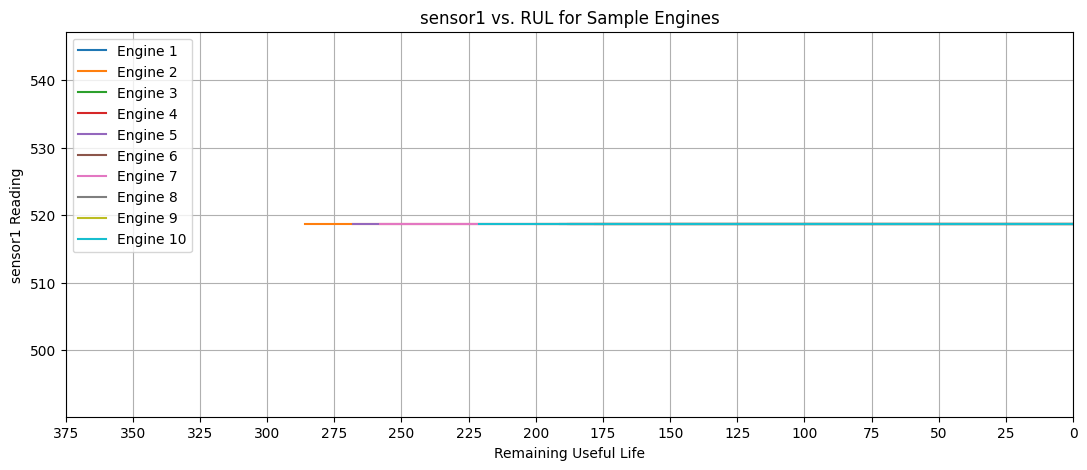

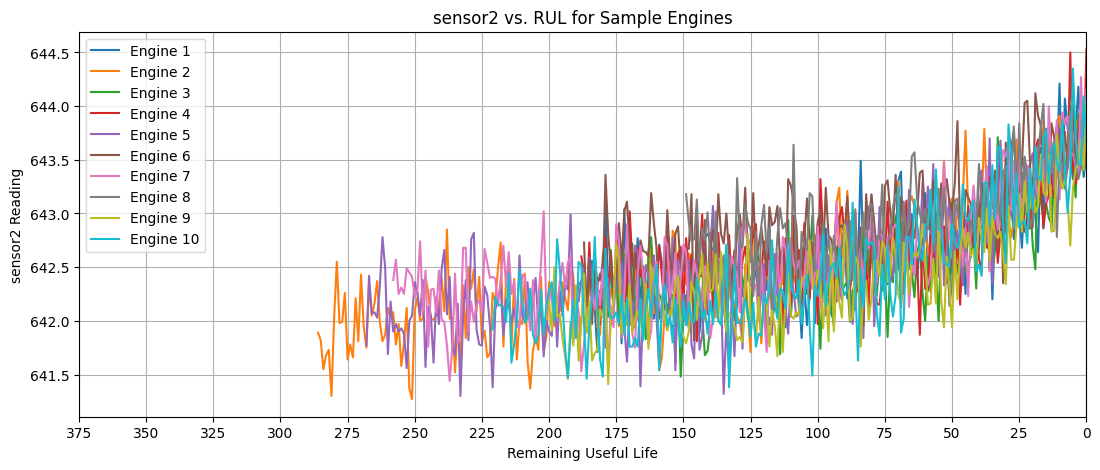

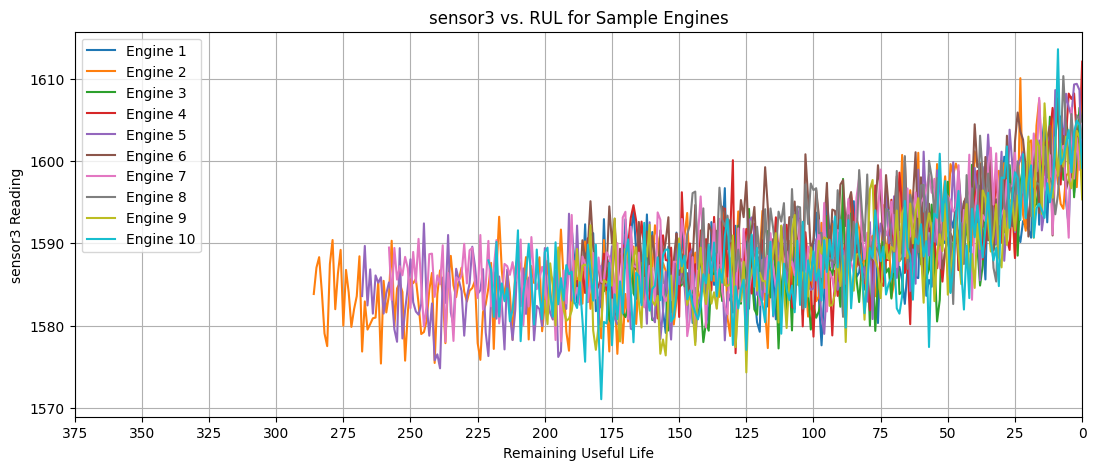

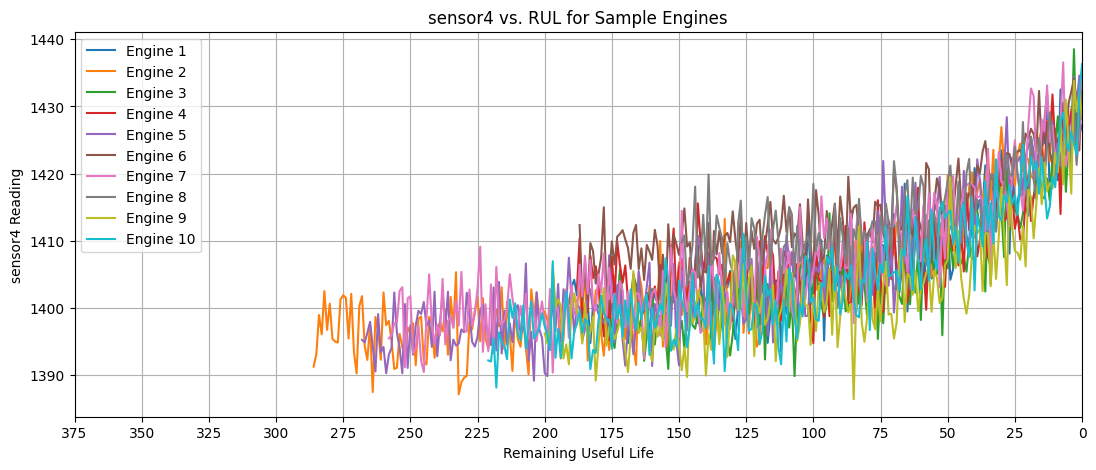

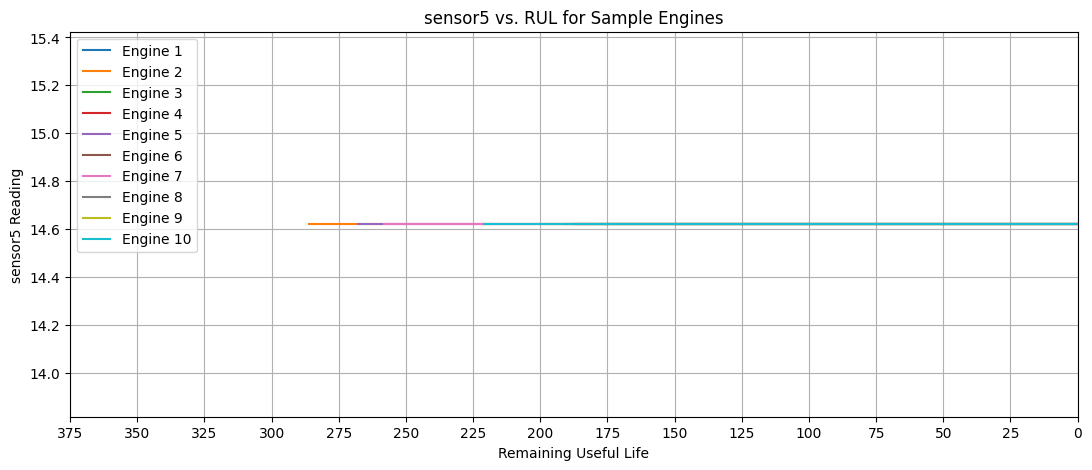

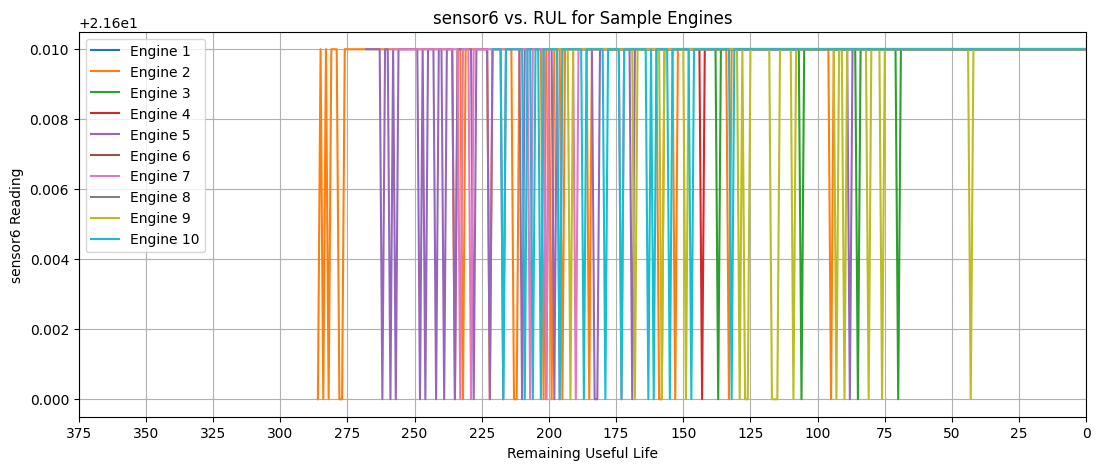

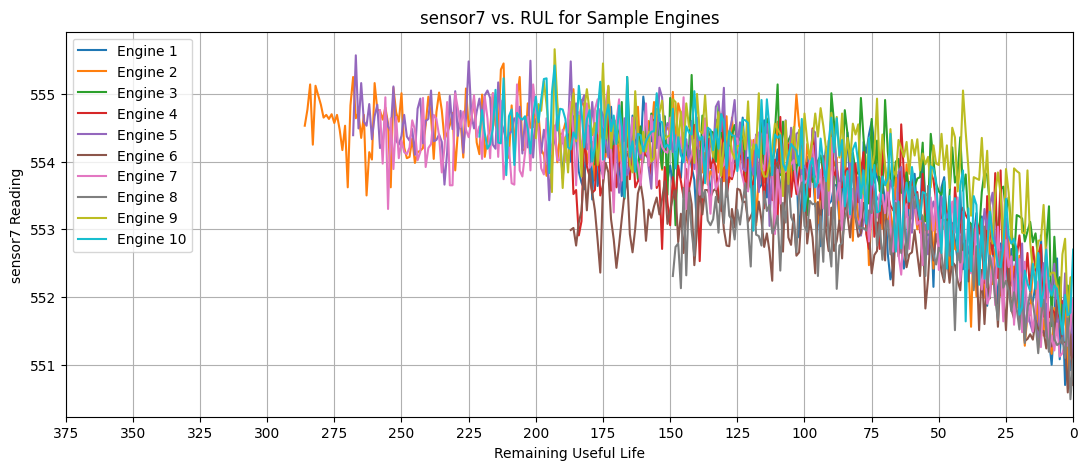

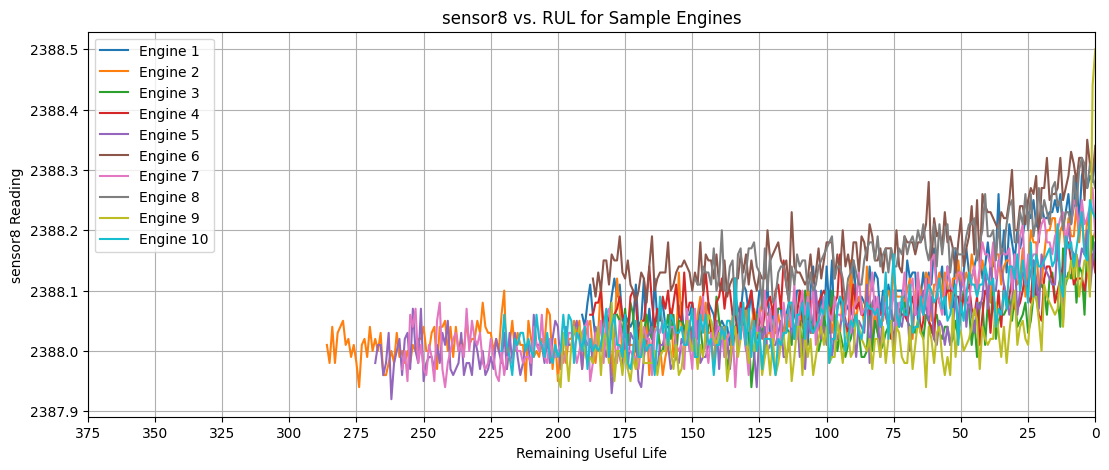

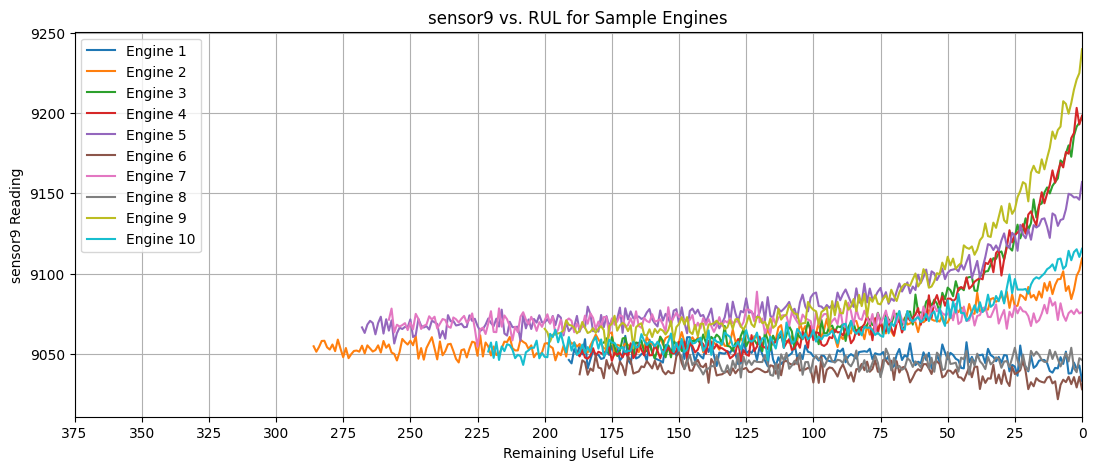

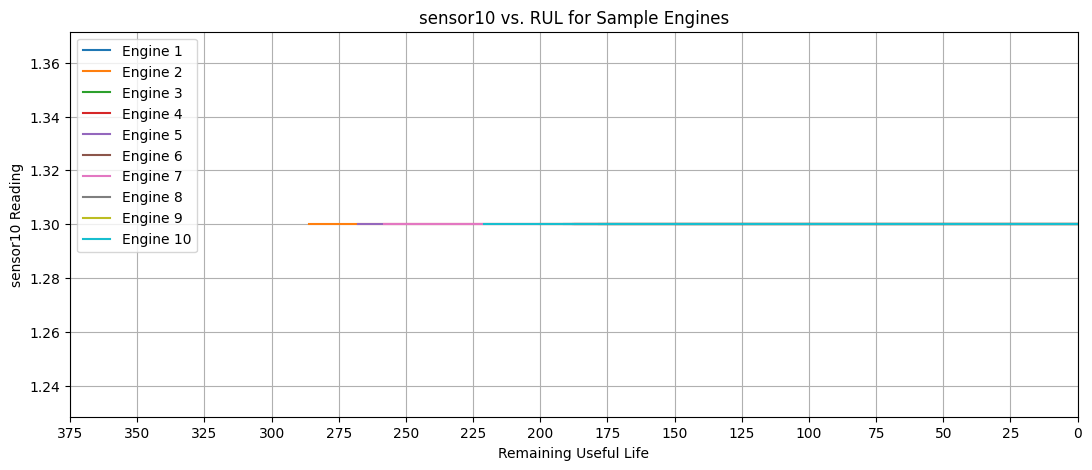

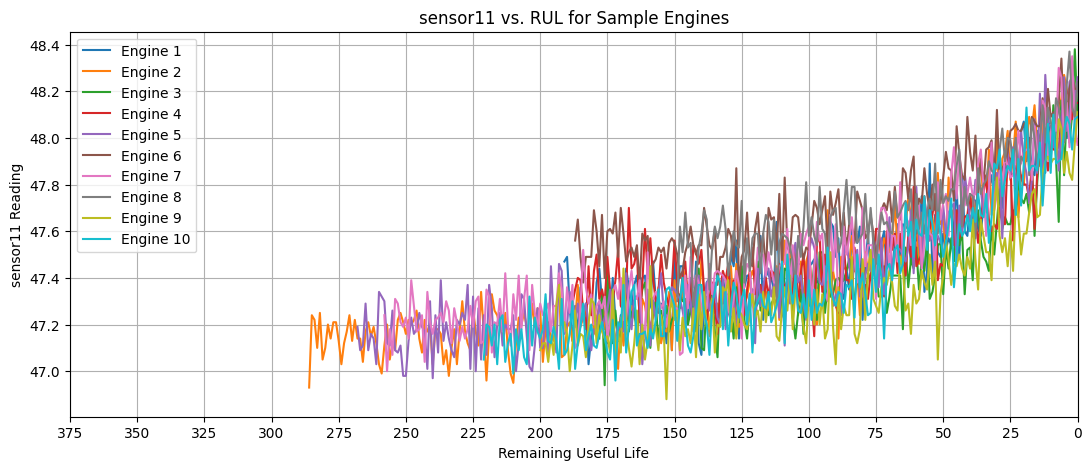

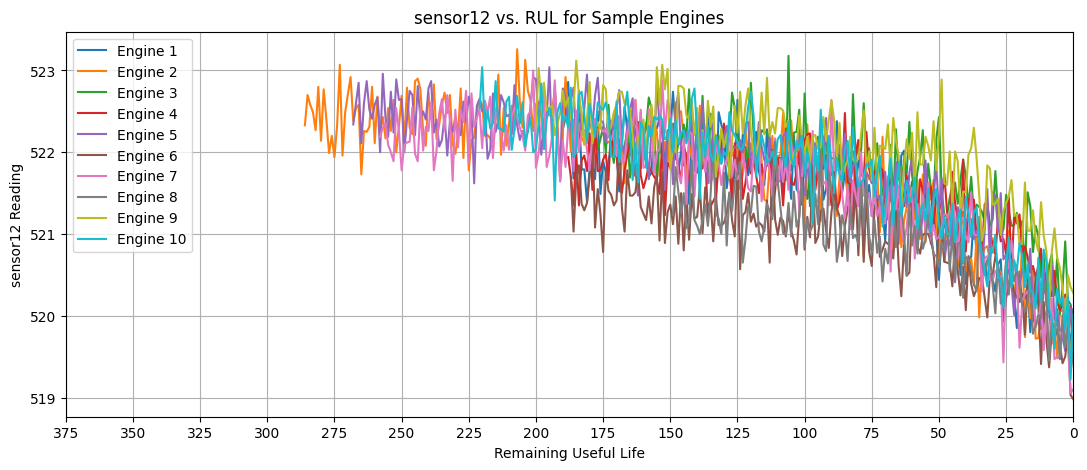

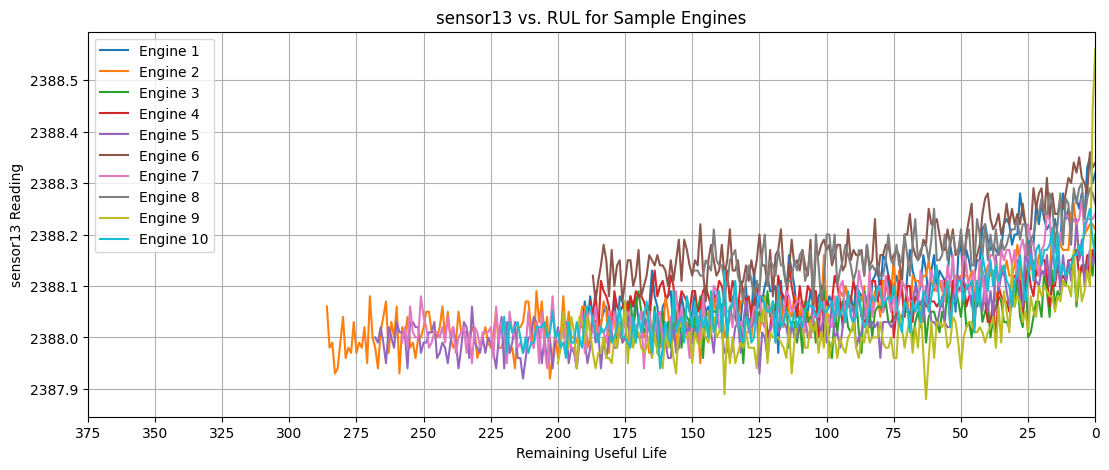

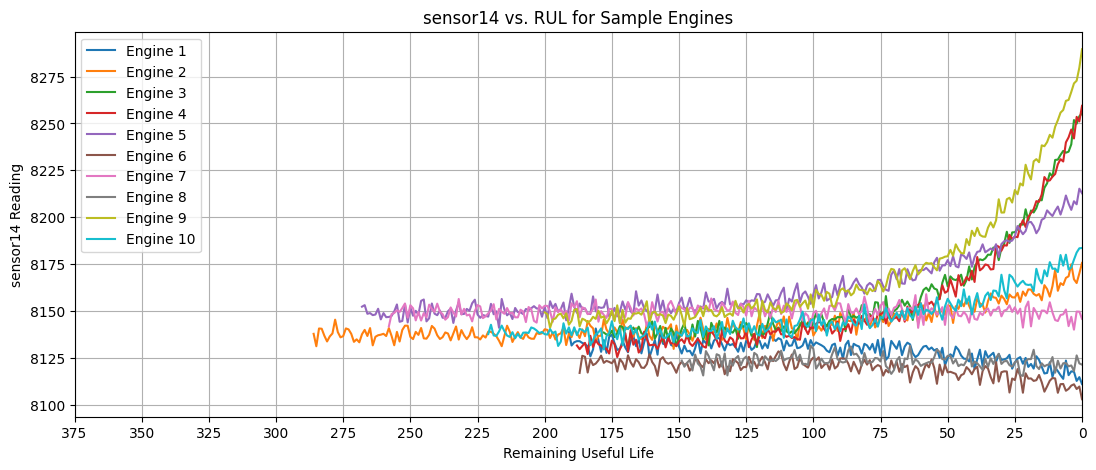

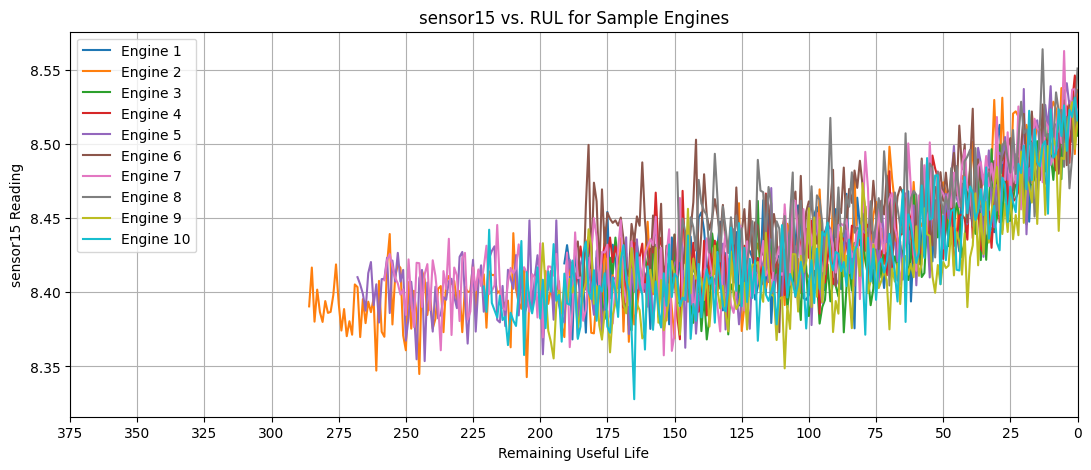

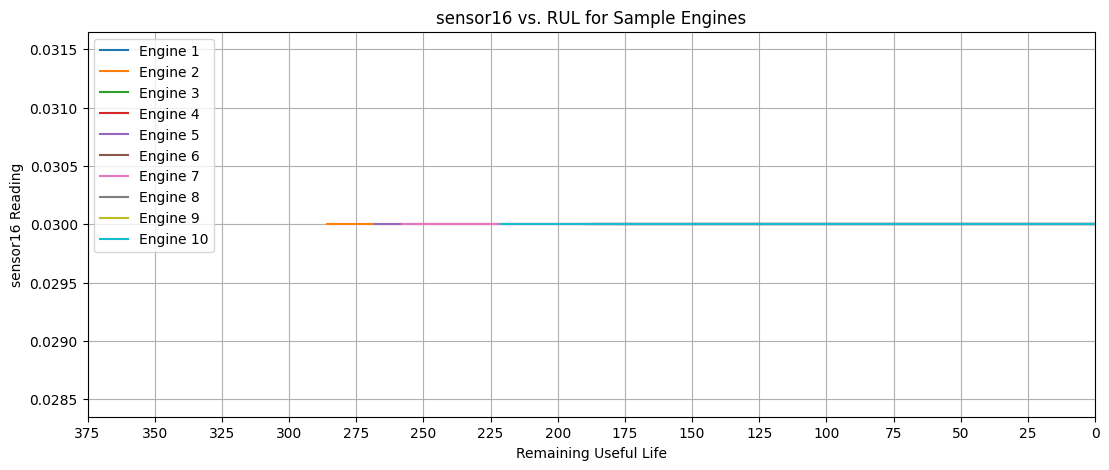

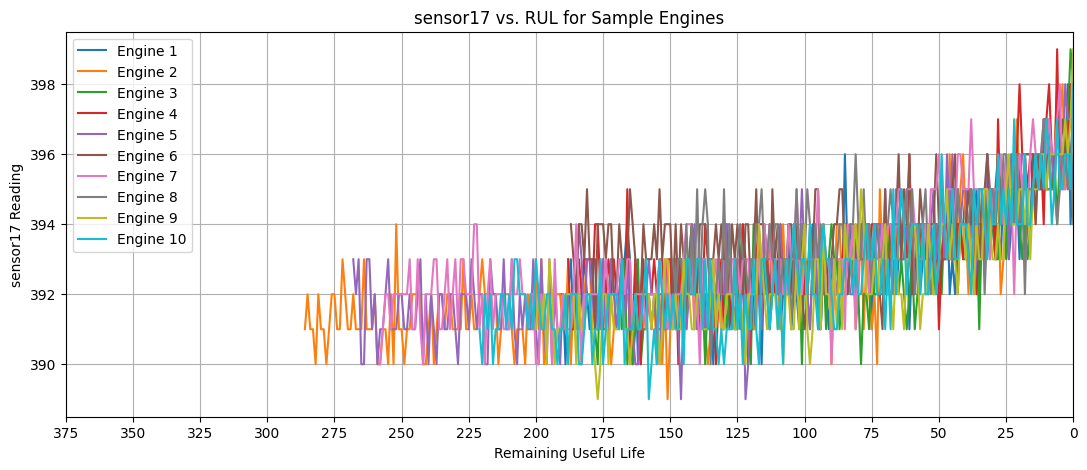

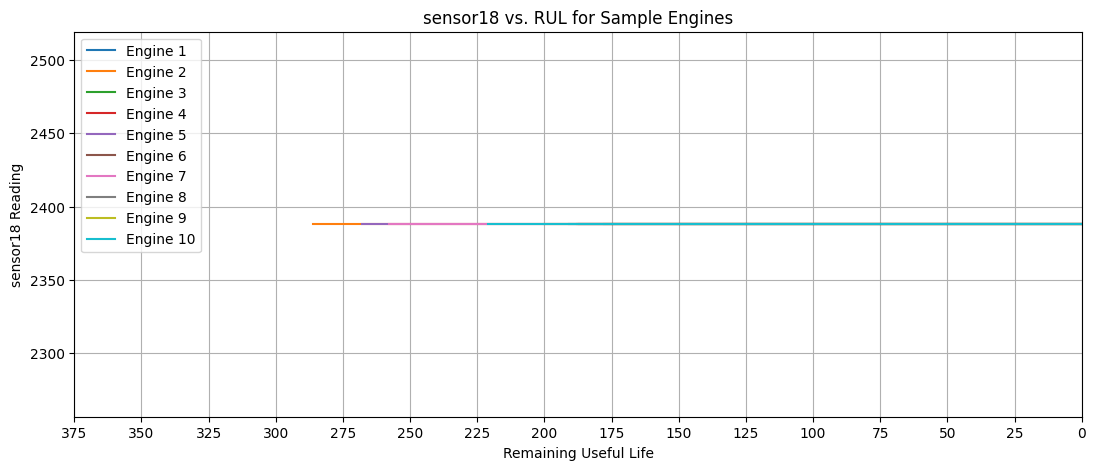

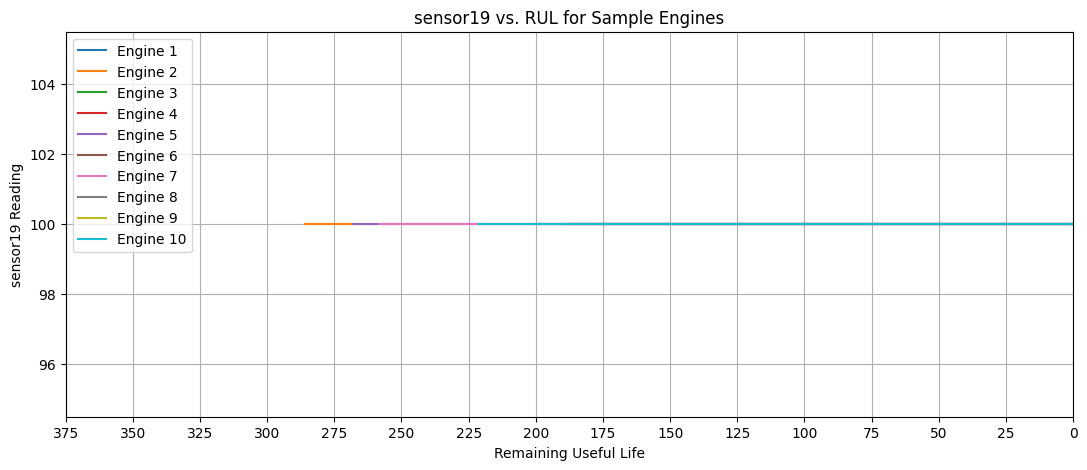

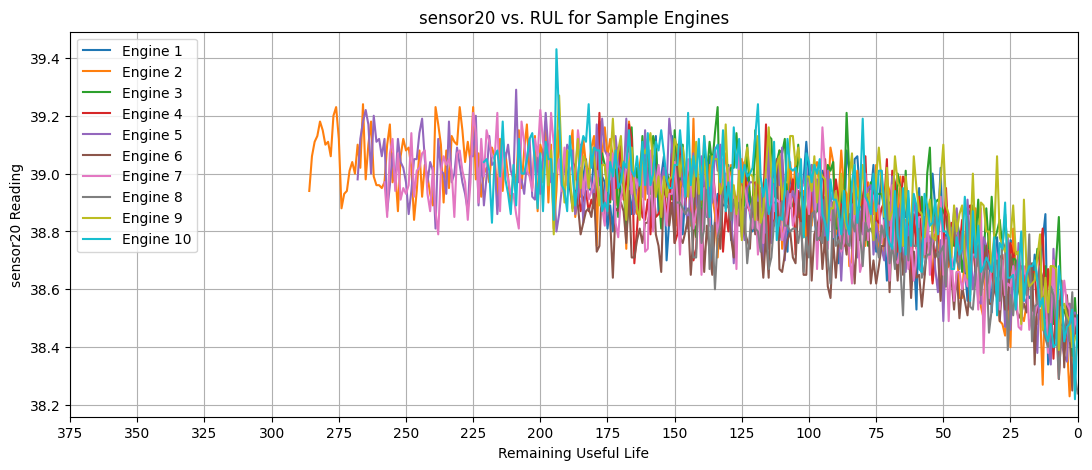

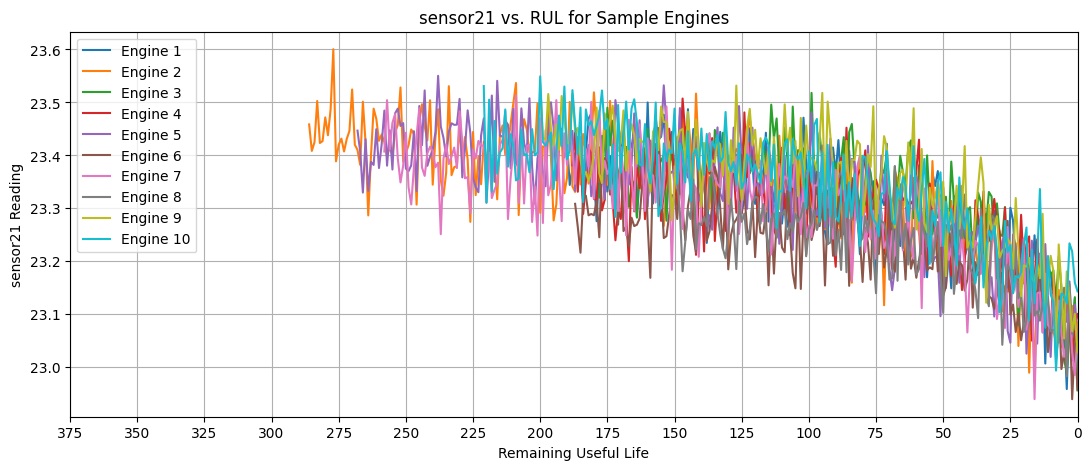

In [10]:
# Get the list of all sensor column names
sensor_cols = [col for col in train_df.columns if 'sensor' in col]

# Select a few engine IDs to visualize on each sensor plot
sample_engine_ids = train_df['engine_id'].unique()[:10]
# Plot the first 10 engines

# Iterate through each sensor column and generate a plot for each sensor
for sensor in sensor_cols:
    plt.figure(figsize=(13, 5))

    plot_count = 0 # Counter for how many engines we've plotted on this figure
    max_plots = 10 # Maximum number of engine trends to show per sensor plot (matches slice above)

    # Iterate through the selected sample engine IDs
    for engine_id in sample_engine_ids:
        if plot_count < max_plots:
            # Filter data for the current engine ID
            engine_data = train_df[train_df['engine_id'] == engine_id]

            # Check if the sensor column exists in the dataframe
            if sensor in engine_data.columns:
                # Plot the sensor reading vs. RUL for this engine
                plt.plot('RUL', sensor, data=engine_data, label=f'Engine {engine_id}')
                plot_count += 1 # Increment counter if we plotted an engine trend
            else:
                 print(f"Warning: Column '{sensor}' not found in dataframe for engine {engine_id}.")
                 # If a sensor is missing for an engine, we might want to skip this engine
                 # for this sensor or handle it differently. For simplicity, we continue.


    # Customizing the plot for the current sensor
    plt.xlim(train_df['RUL'].max(), 0)
    max_rul = train_df['RUL'].max()
    plt.xticks(np.arange(0, max_rul + 25, 25))
    plt.ylabel(f'{sensor} Reading')
    plt.xlabel('Remaining Useful Life')
    plt.title(f'{sensor} vs. RUL for Sample Engines')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [11]:
# Drop uninformative columns
drop_cols = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

# Normalize features
feature_cols = train_df.columns.difference(['engine_id', 'cycle', 'RUL'])
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

#Baseline models: LR and RF

In [12]:
# Prepare data for Linear Regression
X_train_lr = train_df[feature_cols]
y_train_lr = train_df['RUL']

# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Prepare test data for Linear Regression prediction
# For baseline models, we can predict RUL for each time step of the test data.
# Later, we will evaluate on the RUL of the *last* cycle of each engine.
X_test_lr = test_df[feature_cols]

# Predict RUL using the trained Linear Regression model
y_pred_lr_all = lr_model.predict(X_test_lr)

# Add predictions back to the test dataframe for easier analysis
test_df['predicted_RUL_LR'] = y_pred_lr_all

# To evaluate, we need the prediction for the last cycle of each test engine.
# The RUL for the test set (rul_df) corresponds to these last cycles.
# We need to get the predicted RUL from test_df for the row where 'cycle' is max for each 'engine_id'.

# Get the last cycle for each engine in the test set
last_cycles = test_df.groupby('engine_id')['cycle'].max().reset_index()
last_cycles.columns = ['engine_id', 'last_cycle']

# Merge to get the predicted RUL at the last cycle
test_results_lr = pd.merge(last_cycles, test_df, left_on=['engine_id', 'last_cycle'], right_on=['engine_id', 'cycle'], how='left')

# The predicted RUL for evaluation is in the 'predicted_RUL_LR' column of test_results_lr
y_pred_lr_final = test_results_lr['predicted_RUL_LR']

# The true RUL for the test set is in rul_df
y_true_test = rul_df['RUL']

# Evaluate Linear Regression
mse_lr = mean_squared_error(y_true_test, y_pred_lr_final)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_true_test, y_pred_lr_final)

print(f'Linear Regression Mean Squared Error: {mse_lr:.4f}')
print(f'Linear Regression Root Mean Squared Error: {rmse_lr:.4f}')
print(f'Linear Regression R2 Score: {r2_lr:.4f}')

Linear Regression Mean Squared Error: 1020.9708
Linear Regression Root Mean Squared Error: 31.9526
Linear Regression R2 Score: 0.4088


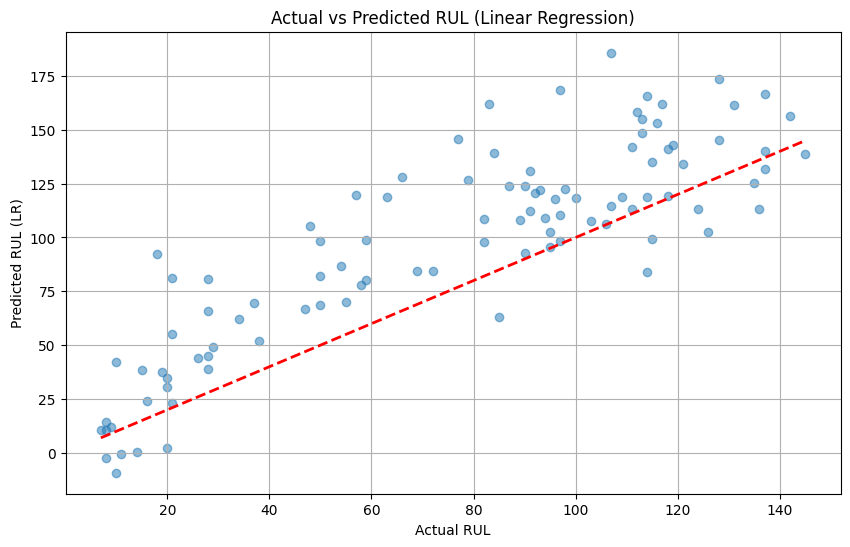

In [13]:
# Visualize Actual vs Predicted RUL for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_true_test, y_pred_lr_final, alpha=0.5)
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL (LR)')
plt.title('Actual vs Predicted RUL (Linear Regression)')
plt.grid(True)
plt.show()

In [16]:
# Prepare data for Random Forest
X_train_rf = train_df[feature_cols]
y_train_rf = train_df['RUL']

# Initialize and train Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_rf, y_train_rf)

# Prepare test data for Random Forest prediction
X_test_rf = test_df[feature_cols]

# Predict RUL using the trained Random Forest model
y_pred_rf_all = rf_model.predict(X_test_rf)

# Add predictions back to the test dataframe
test_df['predicted_RUL_RF'] = y_pred_rf_all

# Get the predicted RUL for the last cycle of each test engine
# (This reuses the last_cycles dataframe created for LR evaluation)
test_results_rf = pd.merge(last_cycles, test_df, left_on=['engine_id', 'last_cycle'], right_on=['engine_id', 'cycle'], how='left')

# The predicted RUL for evaluation is in the 'predicted_RUL_RF' column of test_results_rf
y_pred_rf_final = test_results_rf['predicted_RUL_RF']

# The true RUL for the test set is already in y_true_test (from LR evaluation)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_true_test, y_pred_rf_final)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_true_test, y_pred_rf_final)

print(f'Random Forest Mean Squared Error: {mse_rf:.4f}')
print(f'Random Forest Root Mean Squared Error: {rmse_rf:.4f}')
print(f'Random Forest R2 Score: {r2_rf:.4f}')

Random Forest Mean Squared Error: 1168.0372
Random Forest Root Mean Squared Error: 34.1766
Random Forest R2 Score: 0.3236


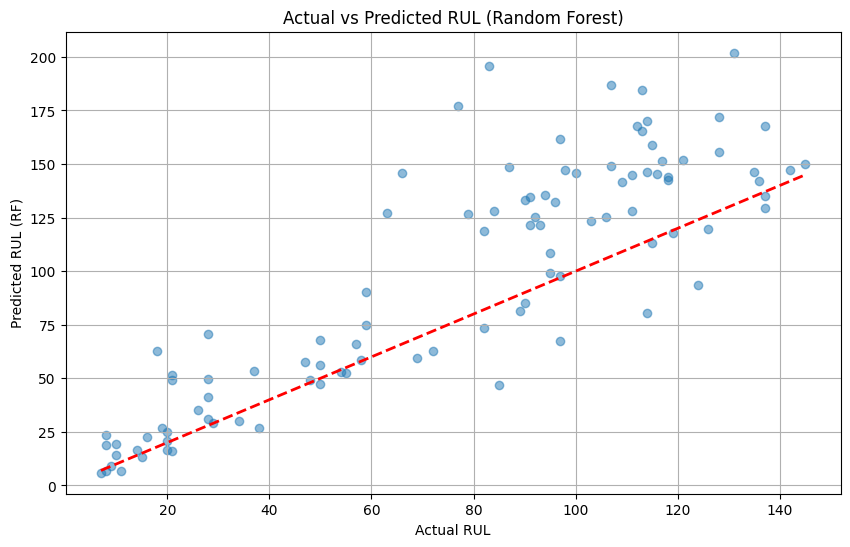

In [17]:
# Visualize Actual vs Predicted RUL for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_true_test, y_pred_rf_final, alpha=0.5)
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL (RF)')
plt.title('Actual vs Predicted RUL (Random Forest)')
plt.grid(True)
plt.show()

#LSTM

In [18]:
def create_sequences(df, seq_len=30):
    X, y = [], []
    for engine in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine]
        for i in range(len(engine_df) - seq_len):
            seq = engine_df.iloc[i:i+seq_len]
            X.append(seq[feature_cols].values)
            y.append(seq.iloc[-1]['RUL'])
    return np.array(X), np.array(y)

X, y = create_sequences(train_df, seq_len=30)
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (17631, 30, 14), y shape: (17631,)


In [19]:
# Split data
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,251 (297.86 KB)

 Trainable params: 76,251 (297.86 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 10054.1553 - val_loss: 12704.7295
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8195.6387 - val_loss: 11004.6387
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6847.7676 - val_loss: 9649.2373
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5883.7729 - val_loss: 8570.9434
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5189.8359 - val_loss: 7726.5557
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4439.0576 - val_loss: 7072.1377
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4054.6741 - val_loss: 6581.5547
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3846.2981 - val_loss: 6213.8730
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3719.2930 - val_loss: 5952.7520
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3594.3022 - val_loss: 5766.4126
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3582.6929

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1741.3774
Validation MSE: 1823.8893
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


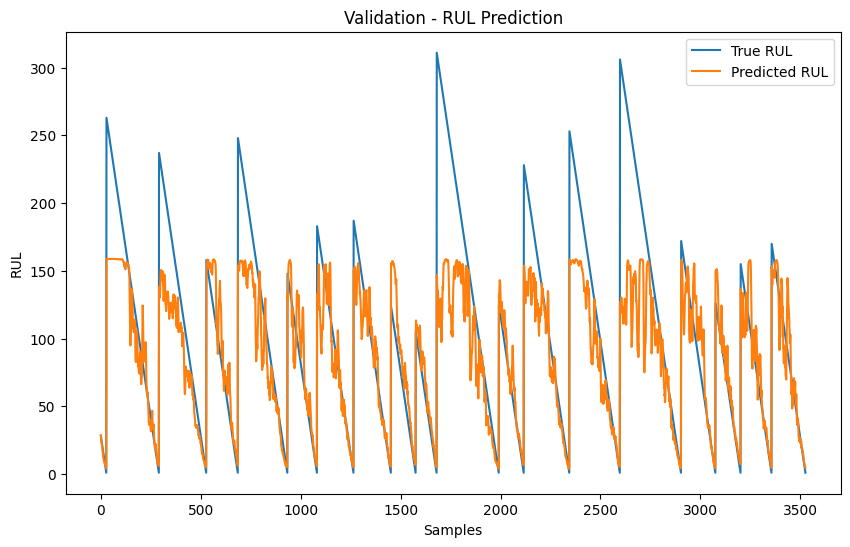

In [21]:
# Evaluate
val_loss = model.evaluate(X_val, y_val)
print(f"Validation MSE: {val_loss:.4f}")

# Plot predictions
y_pred = model.predict(X_val)
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='True RUL')
plt.plot(y_pred, label='Predicted RUL')
plt.title("Validation - RUL Prediction")
plt.xlabel("Samples")
plt.ylabel("RUL")
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


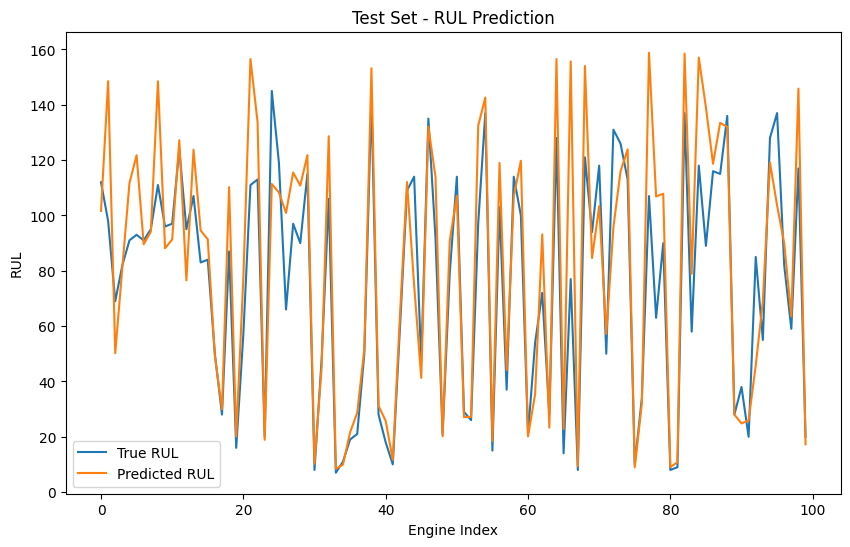

Test RMSE: 20.87


In [24]:
# Prepare sequences from test data
def get_last_sequences(df, seq_len=30):
    X = []
    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id].sort_values('cycle')
        if len(engine_df) >= seq_len:
            seq = engine_df.iloc[-seq_len:][feature_cols].values
            X.append(seq)
    return np.array(X)

X_test = get_last_sequences(test_df)
y_test_pred = model.predict(X_test)

# Compare with true RUL
# Select only the first column of rul_df to ensure matching shape with predictions
true_rul = rul_df.iloc[:, 0].values[:len(y_test_pred)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.title("Test Set - RUL Prediction")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(true_rul, y_test_pred))
print(f"Test RMSE: {rmse:.2f}")


Performance Comparison:
               Model       RMSE        R2
0  Linear Regression  31.952633  0.408774
1      Random Forest  34.176560  0.323610
2               LSTM  20.873045  0.747703


/tmp/ipython-input-25-161662855.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
/tmp/ipython-input-25-161662855.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')


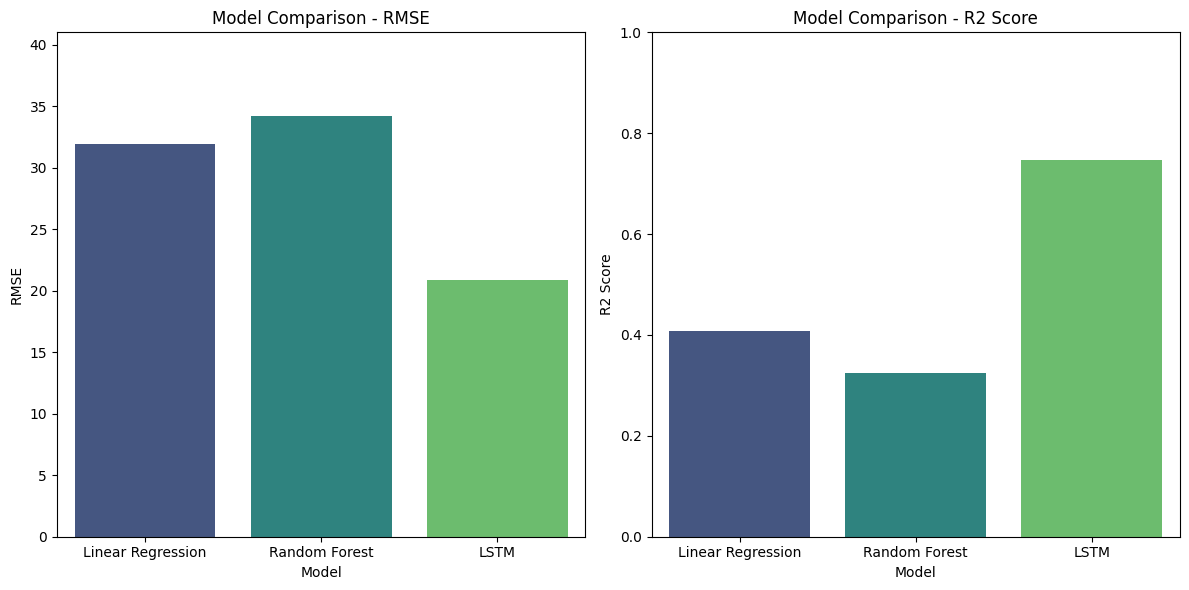

In [25]:
# Store evaluation results
results = {
    'Model': ['Linear Regression', 'Random Forest', 'LSTM'],
    'RMSE': [rmse_lr, rmse_rf, rmse],
    'R2': [r2_lr, r2_rf, r2_score(true_rul, y_test_pred)] # Calculate R2 for LSTM test predictions
}

results_df = pd.DataFrame(results)

print("\nPerformance Comparison:")
print(results_df)

# Visualize performance comparison
plt.figure(figsize=(12, 6))

# RMSE plot
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')
plt.ylim(0, results_df['RMSE'].max() * 1.2)

# R2 plot
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')
plt.title('Model Comparison - R2 Score')
plt.ylabel('R2 Score')
plt.ylim(results_df['R2'].min() * 0.8 if results_df['R2'].min() < 0 else 0, 1)

plt.tight_layout()
plt.show()

## Model Performance Comparison

Based on the evaluation metrics (RMSE and R2 Score) on the test set, we can compare the performance of the three models: Linear Regression, Random Forest, and LSTM.

| Model             | RMSE    | R2 Score |
|-------------------|---------|----------|
| Linear Regression | 31.95   | 0.41     |
| Random Forest     | 34.18   | 0.32     |
| LSTM              | 20.87   | 0.75     |

**Analysis:**

*   **RMSE (Root Mean Squared Error):** RMSE measures the average magnitude of the errors between predicted and actual values. A lower RMSE indicates better performance. The LSTM model achieved the lowest RMSE (20.87), significantly outperforming both Linear Regression (31.95) and Random Forest (34.18). This suggests that the LSTM model's predictions are, on average, closer to the true RUL values.
*   **R2 Score (Coefficient of Determination):** The R2 score represents the proportion of the variance in the dependent variable (RUL) that is predictable from the independent variables (features). An R2 score closer to 1 indicates a better fit of the model to the data. The LSTM model achieved a substantially higher R2 score (0.75) compared to Linear Regression (0.41) and Random Forest (0.32). This indicates that the LSTM model explains a much larger proportion of the variability in RUL on the test set.

**Conclusion:**

The **LSTM model** demonstrates superior performance in predicting Remaining Useful Life (RUL) for aircraft engines on this dataset compared to the baseline Linear Regression and Random Forest models. Its lower RMSE and significantly higher R2 score indicate that it provides more accurate and reliable RUL predictions. This is likely due to the LSTM's ability to capture temporal dependencies and sequential patterns in the sensor data, which are crucial for time-series forecasting tasks like RUL prediction.

#Hypothesis check out


#Hypothesis 1: FFT features from sensor 12 reduce RMSE by ≥10% over baseline LSTM.

In [29]:
#Add FFT Feature Function
from scipy.fft import fft
def add_fft_features(df, sensor_col, prefix='fft_mag'):
    """Add FFT magnitude features for a specified sensor column per engine."""
    fft_features = []

    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id].copy()
        sensor_data = engine_df[sensor_col].values

        fft_magnitude = np.abs(fft(sensor_data))
        engine_df[f'{prefix}_{sensor_col}'] = fft_magnitude

        fft_features.append(engine_df)

    return pd.concat(fft_features, ignore_index=True)


In [30]:
#Apply FFT to Sensor12
train_df_fft = add_fft_features(train_df.copy(), 'sensor12')
test_df_fft = add_fft_features(test_df.copy(), 'sensor12')

# Include the new FFT feature in the feature list
feature_cols_fft = feature_cols.tolist() + ['fft_mag_sensor12']


In [31]:
#Display Samples
print("Training data with FFT feature:")
display(train_df_fft.head())

print("\nTest data with FFT feature:")
display(test_df_fft.head())


Training data with FFT feature:


engine_id  cycle   sensor2   sensor3   sensor4   sensor7   sensor8  \
0          1      1  0.183735  0.406802  0.309757  0.726248  0.242424   
1          1      2  0.283133  0.453019  0.352633  0.628019  0.212121   
2          1      3  0.343373  0.369523  0.370527  0.710145  0.272727   
3          1      4  0.343373  0.256159  0.331195  0.740741  0.318182   
4          1      5  0.349398  0.257467  0.404625  0.668277  0.242424   

    sensor9  sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  \
0  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986  0.333333   
1  0.100242  0.380952  0.765458  0.279412  0.162813  0.411312  0.333333   
2  0.140043  0.250000  0.795309  0.220588  0.171793  0.357445  0.166667   
3  0.124518  0.166667  0.889126  0.294118  0.174889  0.166603  0.333333   
4  0.149960  0.255952  0.746269  0.235294  0.174734  0.402078  0.416667   

   sensor20  sensor21  RUL  fft_mag_sensor12  
0  0.713178  0.724662  191        113.375267  
1  0.666667  0.731014  190         15.285228  
2  0.627907  0.621375  189          8.691228  
3  0.573643  0.662386  188          4.587660  
4  0.589147  0.704502  187          3.055836


Test data with FFT feature:


engine_id  cycle   sensor2   sensor3   sensor4   sensor7   sensor8  \
0          1      1  0.545181  0.310661  0.269413  0.652174  0.212121   
1          1      2  0.150602  0.379551  0.222316  0.805153  0.166667   
2          1      3  0.376506  0.346632  0.322248  0.685990  0.227273   
3          1      4  0.370482  0.285154  0.408001  0.679549  0.196970   
4          1      5  0.391566  0.352082  0.332039  0.694042  0.166667   

    sensor9  sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  \
0  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965  0.333333   
1  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159  0.416667   
2  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638  0.416667   
3  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022  0.250000   
4  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885  0.166667   

   sensor20  sensor21  predicted_RUL_LR  predicted_RUL_RF  fft_mag_sensor12  
0  0.558140  0.661834        158.458011            177.22         21.701493  
1  0.682171  0.686827        167.959666            166.09          0.192999  
2  0.728682  0.721348        147.961030            151.54          0.122766  
3  0.666667  0.662110        157.079093            159.31          0.219010  
4  0.658915  0.716377        169.981252            190.44          0.209497

In [32]:
#Prepare Sequences (Using Existing Function)
X_fft, y_fft = create_sequences(train_df_fft, seq_len=30)
print(f"X_fft shape: {X_fft.shape}, y_fft shape: {y_fft.shape}")


X_fft shape: (17631, 30, 14), y_fft shape: (17631,)


In [33]:
#Train-Validation Split
split_idx = int(0.8 * len(X_fft))
X_train_fft, X_val_fft = X_fft[:split_idx], X_fft[split_idx:]
y_train_fft, y_val_fft = y_fft[:split_idx], y_fft[split_idx:]


In [34]:
#Build LSTM + FFT Model
model_fft = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_fft.shape[1], X_train_fft.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model_fft.compile(optimizer='adam', loss='mse')
model_fft.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 100)        │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,251 (297.86 KB)

 Trainable params: 76,251 (297.86 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
#Train the Model
history_fft = model_fft.fit(
    X_train_fft, y_train_fft,
    epochs=50, batch_size=64,
    validation_data=(X_val_fft, y_val_fft)
)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 10206.5908 - val_loss: 12697.6582
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8276.8145 - val_loss: 11003.4375
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6820.8223 - val_loss: 9645.9131
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5870.5913 - val_loss: 8569.3340
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5102.8945 - val_loss: 7727.0156
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 4542.9502 - val_loss: 7073.7686
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4181.5991 - val_loss: 6580.3506
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3929.0151 - val_loss: 6217.7246
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3574.0500 - val_loss: 5950.7378
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3579.2014 - val_loss: 5763.8618
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3471.6

In [36]:
#Evaluate on Validation Set
val_loss_fft = model_fft.evaluate(X_val_fft, y_val_fft)
print(f"Validation MSE with FFT features: {val_loss_fft:.4f}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1637.8102
Validation MSE with FFT features: 1790.9199


In [37]:
#Test Predictions
X_test_fft = get_last_sequences(test_df_fft, seq_len=30)
y_test_pred_fft = model_fft.predict(X_test_fft)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


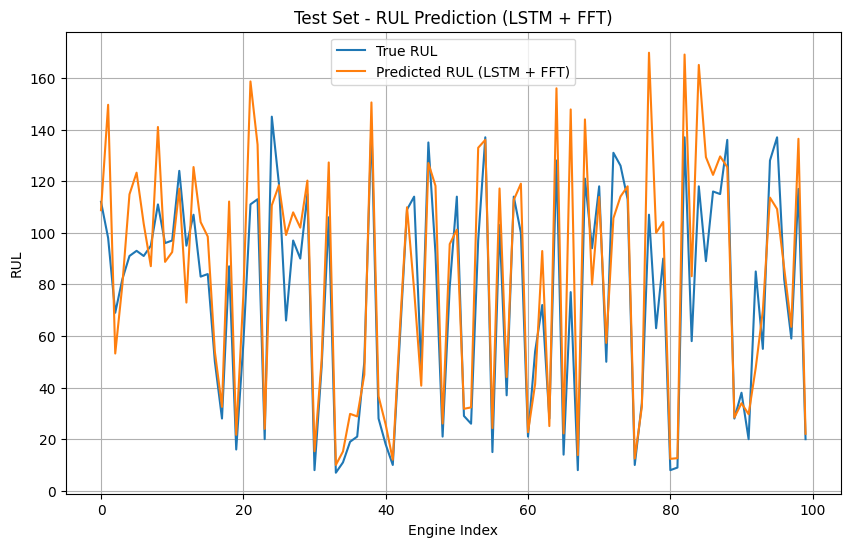

In [38]:
#Compare Predictions vs. True RUL
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL')
plt.plot(y_test_pred_fft, label='Predicted RUL (LSTM + FFT)')
plt.title("Test Set - RUL Prediction (LSTM + FFT)")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
#Performance Metrics
rmse_fft = np.sqrt(mean_squared_error(true_rul, y_test_pred_fft))
r2_fft = r2_score(true_rul, y_test_pred_fft)

print(f"Test RMSE with FFT features: {rmse_fft:.2f}")


Test RMSE with FFT features: 20.43


In [40]:
#Combine with Previous Results
results_df_fft = pd.DataFrame({
    'Model': ['LSTM + FFT'],
    'RMSE': [rmse_fft],
    'R2': [r2_fft]
})

results_df_combined = pd.concat([results_df, results_df_fft], ignore_index=True)

print("\nPerformance Comparison (including LSTM + FFT):")
display(results_df_combined)



Performance Comparison (including LSTM + FFT):


Model       RMSE        R2
0  Linear Regression  31.952633  0.408774
1      Random Forest  34.176560  0.323610
2               LSTM  20.873045  0.747703
3         LSTM + FFT  20.427046  0.758370

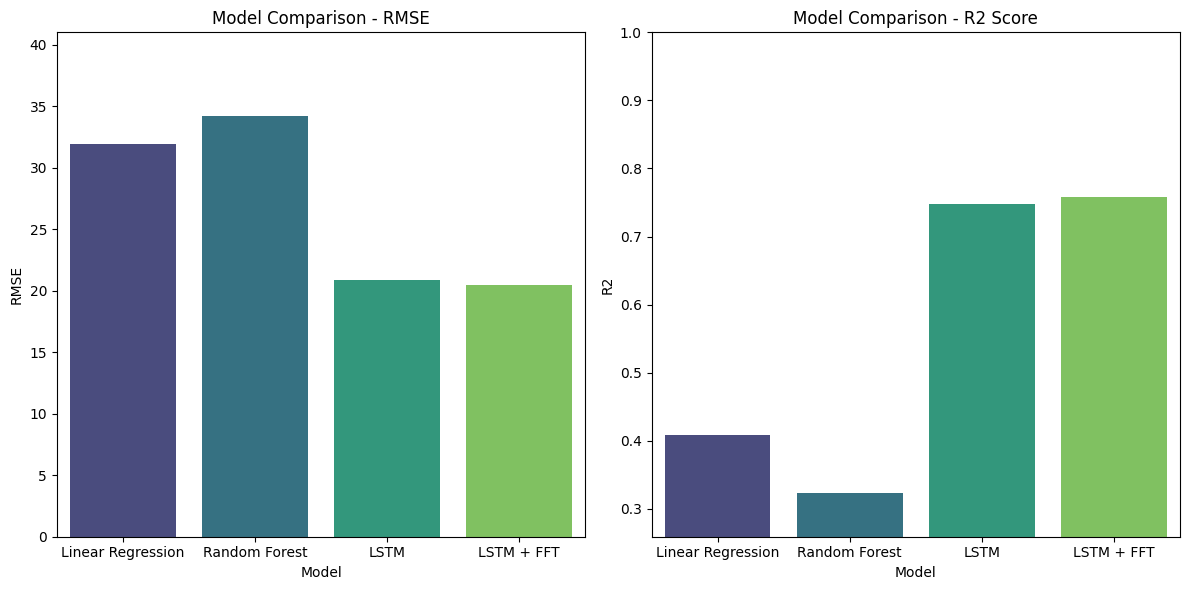

In [41]:
#Visualize Performance
plt.figure(figsize=(12, 6))

# RMSE bar plot
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results_df_combined, palette='viridis')
plt.title('Model Comparison - RMSE')
plt.ylim(0, results_df_combined['RMSE'].max() * 1.2)

# R2 bar plot
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2', data=results_df_combined, palette='viridis')
plt.title('Model Comparison - R2 Score')
plt.ylim(max(0, results_df_combined['R2'].min() * 0.8), 1)

plt.tight_layout()
plt.show()


#Hypothesis 2: A CNN-LSTM hybrid outperforms a pure LSTM model with RMSE < 20 cycles on FD001.

In [42]:
#Reshape Data for CNN-LSTM (Add Channel Dimension)
# Shape before: (samples, timesteps, features)
# CNN requires: (samples, timesteps, features, channels)
X_train_cnn_lstm = np.expand_dims(X_train, axis=-1)
X_val_cnn_lstm = np.expand_dims(X_val, axis=-1)

print(f"X_train_cnn_lstm shape: {X_train_cnn_lstm.shape}")
print(f"X_val_cnn_lstm shape: {X_val_cnn_lstm.shape}")


X_train_cnn_lstm shape: (14104, 30, 14, 1)
X_val_cnn_lstm shape: (3527, 30, 14, 1)


In [43]:
#Build CNN-LSTM Hybrid Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, Input

cnn_lstm_model = Sequential([
    Input(shape=(X_train_cnn_lstm.shape[1], X_train_cnn_lstm.shape[2], 1)),
    TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

cnn_lstm_model.compile(optimizer='adam', loss='mse')
cnn_lstm_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 12, 64)     │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 6, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 384)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │       194,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,507 (876.98 KB)

 Trainable params: 224,507 (876.98 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
#Train CNN-LSTM Model
history_cnn_lstm = cnn_lstm_model.fit(
    X_train_cnn_lstm, y_train,
    epochs=50, batch_size=64,
    validation_data=(X_val_cnn_lstm, y_val)
)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 10105.4727 - val_loss: 12630.0527
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 8126.3540 - val_loss: 10973.5693
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 6948.3247 - val_loss: 9644.1768
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 5813.9453 - val_loss: 8584.5352
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 4999.6309 - val_loss: 7745.0220
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 4728.9653 - val_loss: 7100.7168
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 4157.7637 - val_loss: 6604.1665
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 3835.8650 - val_loss: 6239.5386
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 3819.6973 - val_loss: 5973.5225
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 3605.6040 - val_loss: 5785.9189
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 

In [45]:
#Prepare and Reshape Test Data
X_test_cnn_lstm = get_last_sequences(test_df)
X_test_cnn_lstm = np.expand_dims(X_test_cnn_lstm, axis=-1)


In [46]:
#Predict and Evaluate
y_test_pred_cnn_lstm = cnn_lstm_model.predict(X_test_cnn_lstm)

rmse_cnn_lstm = np.sqrt(mean_squared_error(true_rul, y_test_pred_cnn_lstm))
r2_cnn_lstm = r2_score(true_rul, y_test_pred_cnn_lstm)

print(f"Test RMSE (CNN-LSTM): {rmse_cnn_lstm:.2f}")
print(f"Test R2 (CNN-LSTM): {r2_cnn_lstm:.4f}")


1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 346ms/step
Test RMSE (CNN-LSTM): 23.94
Test R2 (CNN-LSTM): 0.6680


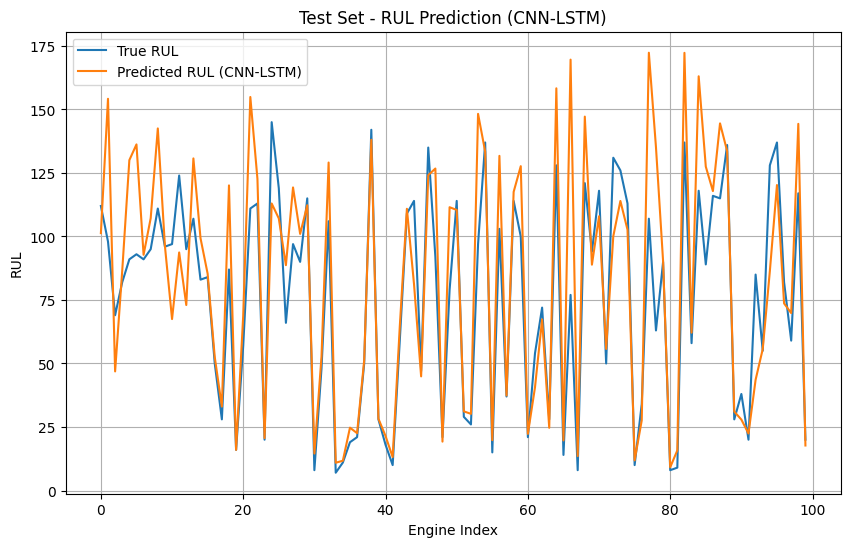

In [47]:
#Plot Predictions vs True RUL
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL')
plt.plot(y_test_pred_cnn_lstm, label='Predicted RUL (CNN-LSTM)')
plt.title("Test Set - RUL Prediction (CNN-LSTM)")
plt.xlabel("Engine Index")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()


In [48]:
#Save Results and Update Comparison
results_df_cnn_lstm = pd.DataFrame({
    'Model': ['CNN-LSTM'],
    'RMSE': [rmse_cnn_lstm],
    'R2': [r2_cnn_lstm]
})

# Remove old CNN-LSTM row if exists
results_df_combined = results_df_combined[results_df_combined['Model'] != 'CNN-LSTM']

# Add new results
results_df_combined = pd.concat([results_df_combined, results_df_cnn_lstm], ignore_index=True)

# Display update
print("\nUpdated Model Performance (CNN-LSTM included):")
display(results_df_combined)


Updated Model Performance (CNN-LSTM included):


Model       RMSE        R2
0  Linear Regression  31.952633  0.408774
1      Random Forest  34.176560  0.323610
2               LSTM  20.873045  0.747703
3         LSTM + FFT  20.427046  0.758370
4           CNN-LSTM  23.944694  0.667984

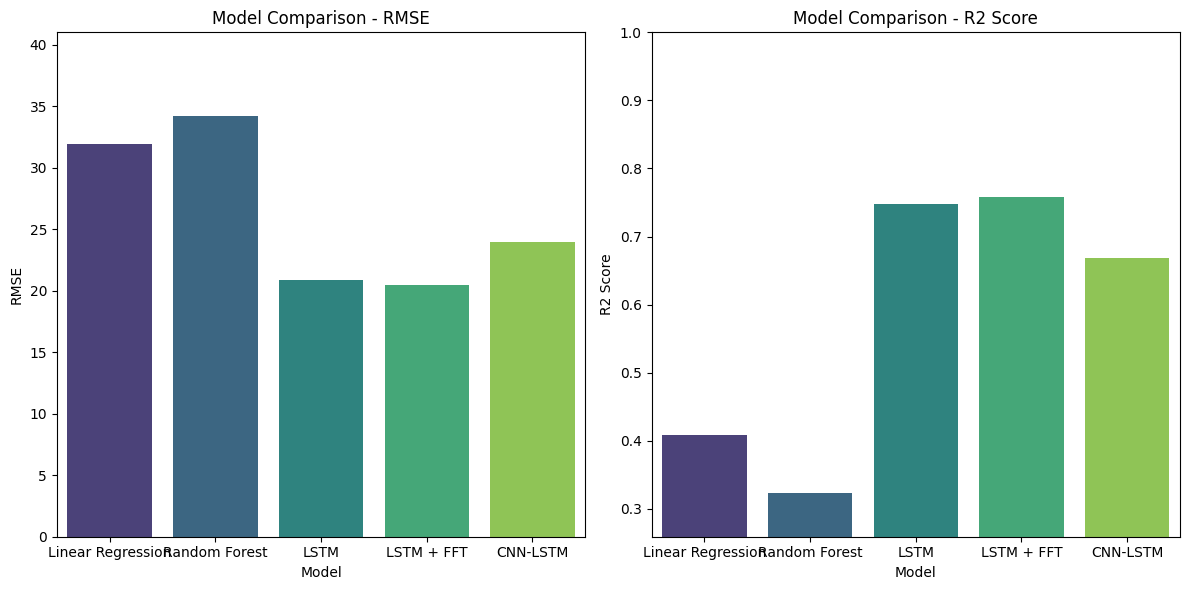

In [49]:
#Visualization of Performance Metrics
plt.figure(figsize=(12, 6))

# RMSE Bar Chart
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results_df_combined, palette='viridis')
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')
plt.ylim(0, results_df_combined['RMSE'].max() * 1.2)

# R2 Bar Chart
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2', data=results_df_combined, palette='viridis')
plt.title('Model Comparison - R2 Score')
plt.ylabel('R2 Score')
plt.ylim(max(results_df_combined['R2'].min() * 0.8, 0), 1)

plt.tight_layout()
plt.show()


#Hypothesis 3: Model trained on early-life cycles provides a warning 30% earlier than midpoint-cycle trained models.

In [53]:
#Define Early- and Midpoint-Life Sequence Generators
from scipy.fft import fft
def create_phase_sequences(df, seq_len=30, split_percent=0.5, phase='early'):
    """
    Creates sequences from either early-life or midpoint-life data per engine.
    """
    X, y = [], [] # Initialize X and y here, before the engine loop
    rul_max = df.groupby('engine_id')['cycle'].max().reset_index()
    rul_max.columns = ['engine_id', 'max_cycle']

    for engine in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine].sort_values('cycle')
        max_cycle = rul_max[rul_max['engine_id'] == engine]['max_cycle'].iloc[0]
        split_cycle = int(max_cycle * split_percent)

        # Choose cycle slice
        if phase == 'early':
            engine_phase_df = engine_df[engine_df['cycle'] <= split_cycle]
        elif phase == 'mid':
            engine_phase_df = engine_df[engine_df['cycle'] > split_cycle]
        else:
             # Handle unknown phase or use default
             engine_phase_df = pd.DataFrame()


        # Build sequences
        if len(engine_phase_df) >= seq_len:
            for i in range(len(engine_phase_df) - seq_len + 1):
                seq = engine_phase_df.iloc[i:i+seq_len][feature_cols].values
                rul_target = engine_df.loc[engine_phase_df.iloc[i+seq_len-1].name, 'RUL']
                X.append(seq) # Append the sequence to X
                y.append(rul_target)

    return np.array(X), np.array(y) # Ensure two arrays are always returned

In [55]:
#Generate Training Data for Early and Mid Cycles
# Create sequences
X_early, y_early = create_phase_sequences(train_df, phase='early')
X_mid, y_mid = create_phase_sequences(train_df, phase='mid')

# Split into train/val
split_e = int(0.8 * len(X_early))
split_m = int(0.8 * len(X_mid))

X_train_e, X_val_e = X_early[:split_e], X_early[split_e:]
y_train_e, y_val_e = y_early[:split_e], y_early[split_e:]

X_train_m, X_val_m = X_mid[:split_m], X_mid[split_m:]
y_train_m, y_val_m = y_mid[:split_m], y_mid[split_m:]

In [56]:
#Define & Train LSTM Models for Each Phase
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train early-life model
model_early = build_lstm_model((30, X_train_e.shape[2]))
history_early = model_early.fit(X_train_e, y_train_e, epochs=50, batch_size=64, validation_data=(X_val_e, y_val_e))

# Train midpoint-life model
model_mid = build_lstm_model((30, X_train_m.shape[2]))
history_mid = model_mid.fit(X_train_m, y_train_m, epochs=50, batch_size=64, validation_data=(X_val_m, y_val_m))


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 21426.3145 - val_loss: 27535.9062
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 19130.3555 - val_loss: 26016.9883
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17788.5293 - val_loss: 24627.9102
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16785.2988 - val_loss: 23324.2129
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 15390.2324 - val_loss: 22088.2871
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14584.3018 - val_loss: 20916.5742
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 13370.5918 - val_loss: 19803.9785
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 12724.6797 - val_loss: 18754.1562
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 12002.4844 - val_loss: 17752.0723
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11069.6660 - val_loss: 16803.1426
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10175.1436 -

In [57]:
#Prepare Test Sequences Across Full Life
def create_test_sequences(df, seq_len=30):
    X, y, engines, cycles = [], [], [], []

    test_max = df.groupby('engine_id')['cycle'].max().reset_index()
    test_max.columns = ['engine_id', 'max_cycle']

    for engine in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine].sort_values('cycle')
        max_cycle = test_max[test_max['engine_id'] == engine]['max_cycle'].iloc[0]

        for i in range(seq_len - 1, len(engine_df)):
            seq = engine_df.iloc[i - seq_len + 1 : i + 1][feature_cols].values
            rul = max_cycle - engine_df.iloc[i]['cycle']
            X.append(seq)
            y.append(rul)
            engines.append(engine)
            cycles.append(engine_df.iloc[i]['cycle'])

    return np.array(X), np.array(y), engines, cycles

X_test_all, y_test_all, test_engines, test_cycles = create_test_sequences(test_df)


In [58]:
#Predict with Both Models
y_pred_early = model_early.predict(X_test_all).flatten()
y_pred_mid = model_mid.predict(X_test_all).flatten()


319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [59]:
#Analyze Warning Lead Times
def compute_warning_lead(predictions, true_rul, engines, cycles, threshold=30):
    lead_times = {}
    for idx, engine_id in enumerate(engines):
        if predictions[idx] <= threshold and engine_id not in lead_times:
            actual_lead = true_rul[idx] - threshold
            lead_times[engine_id] = actual_lead
    return lead_times

lead_early = compute_warning_lead(y_pred_early, y_test_all, test_engines, test_cycles)
lead_mid = compute_warning_lead(y_pred_mid, y_test_all, test_engines, test_cycles)

# Compare
mean_early = np.mean(list(lead_early.values()))
mean_mid = np.mean(list(lead_mid.values()))
improvement = ((mean_early - mean_mid) / mean_mid) * 100

print(f"Mean Lead (Early): {mean_early:.2f} cycles")
print(f"Mean Lead (Mid): {mean_mid:.2f} cycles")
print(f"Improvement: {improvement:.2f}%")


Mean Lead (Early): nan cycles
Mean Lead (Mid): -18.43 cycles
Improvement: nan%


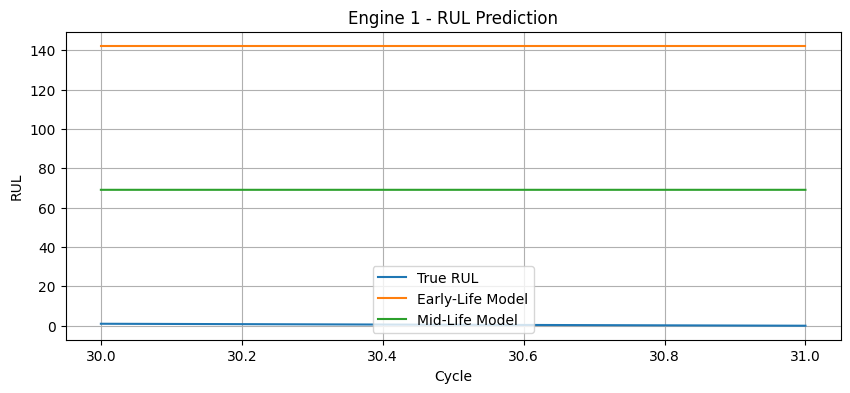

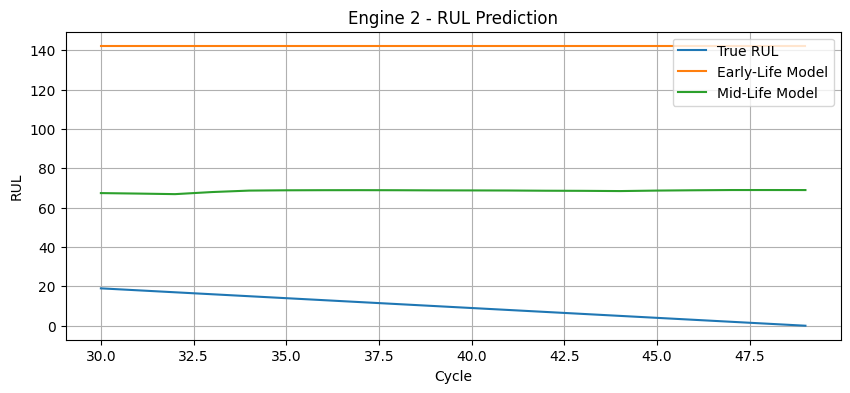

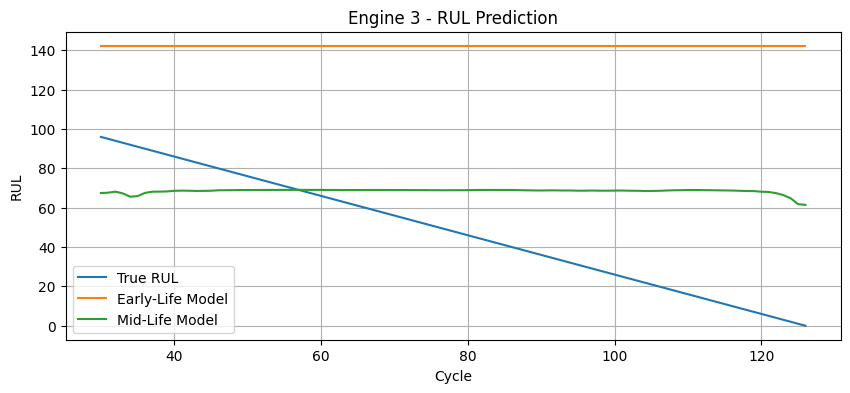

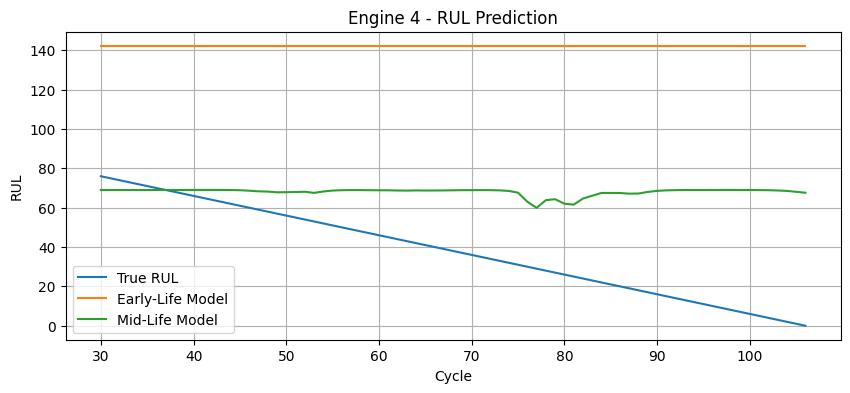

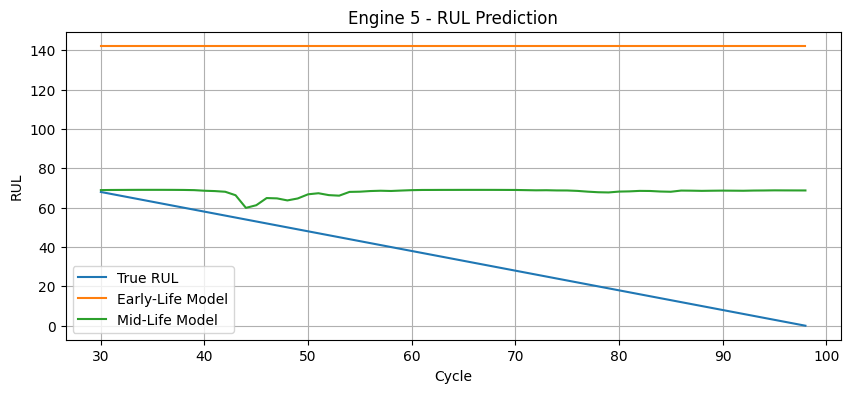

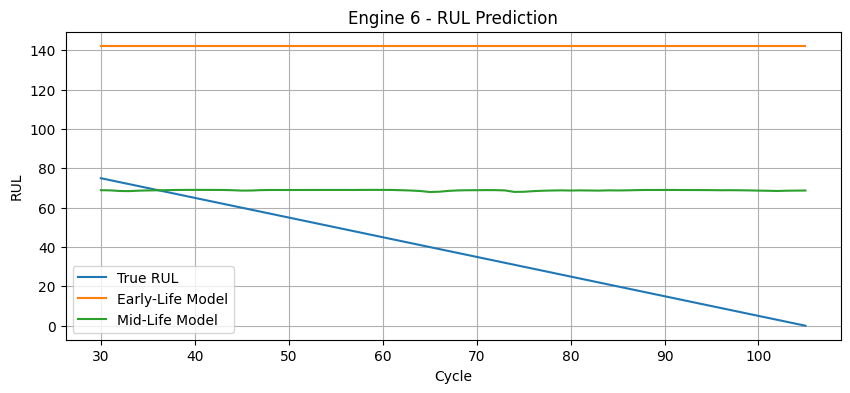

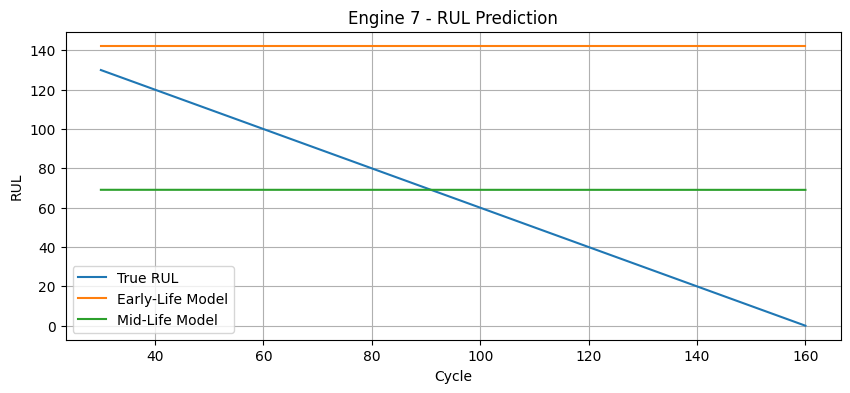

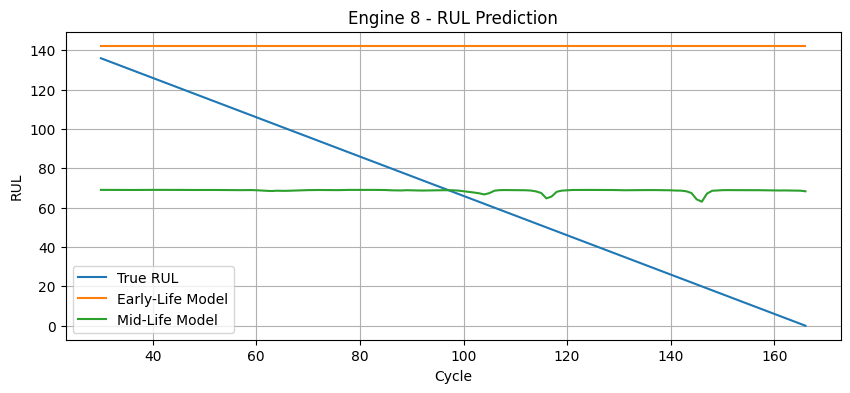

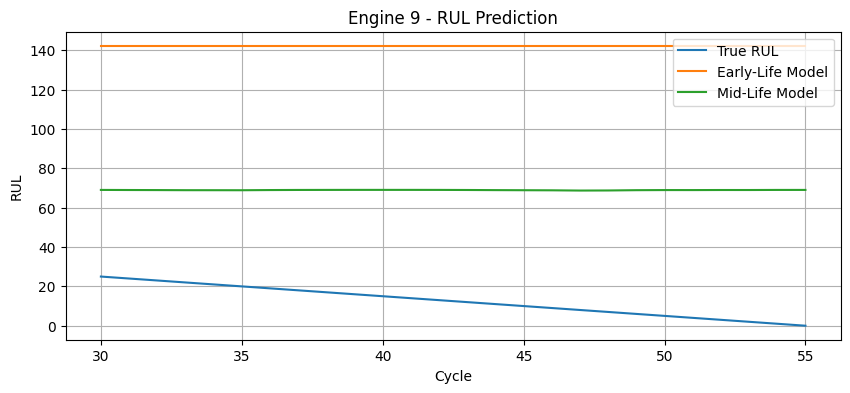

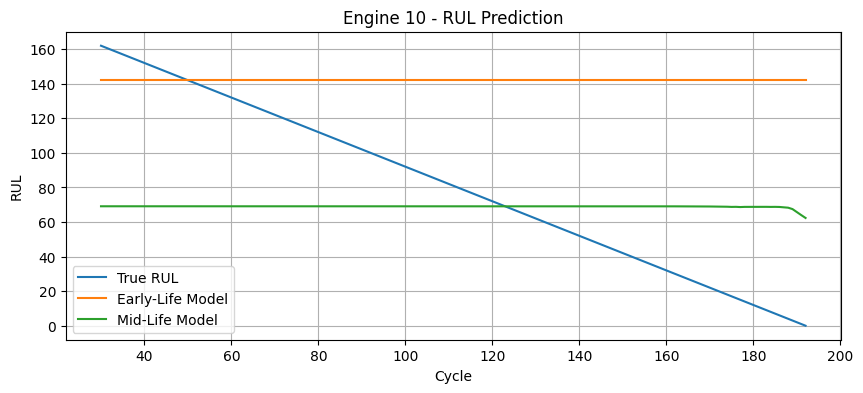

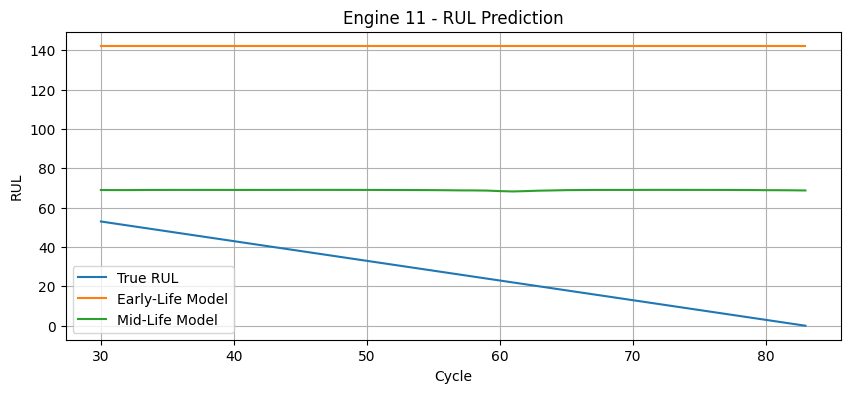

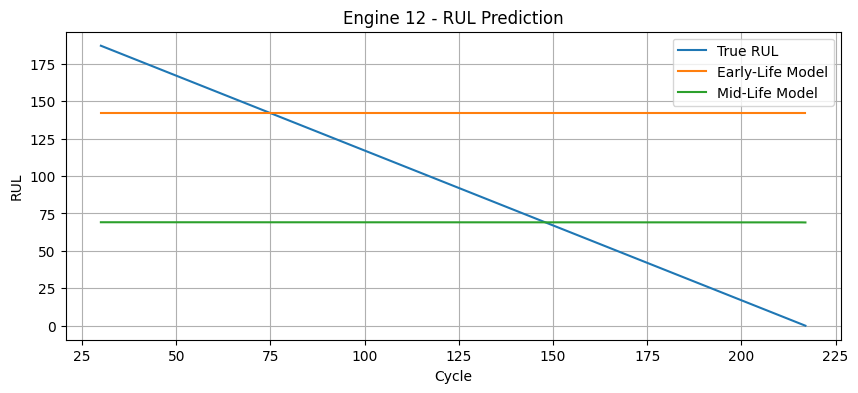

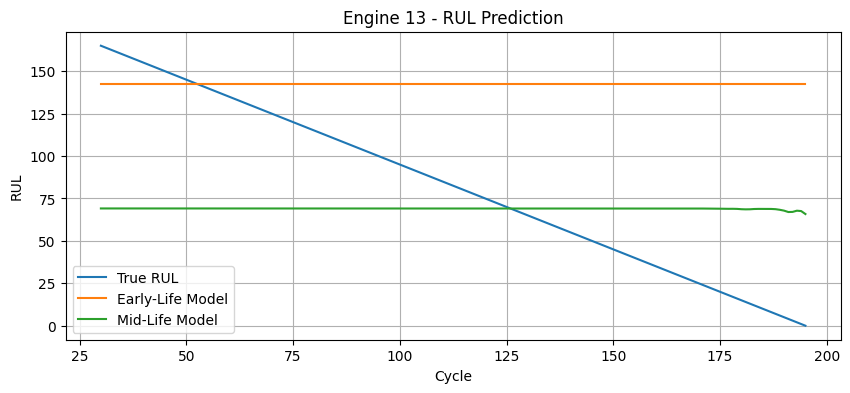

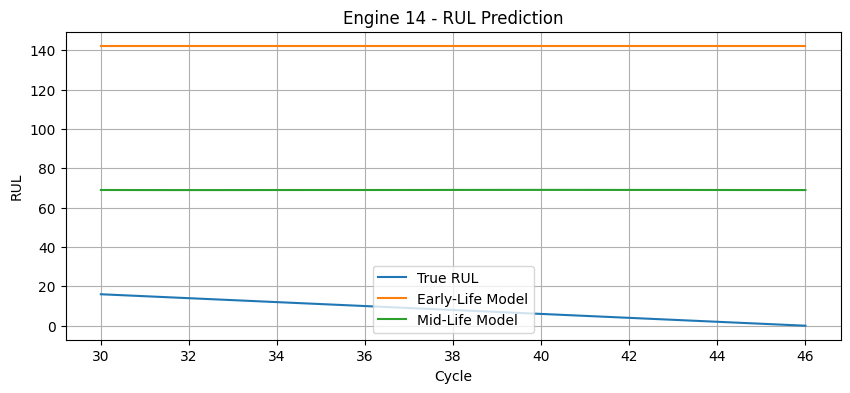

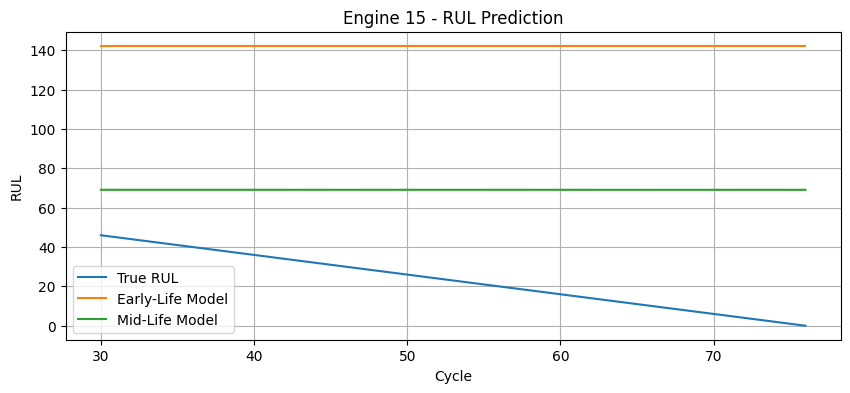

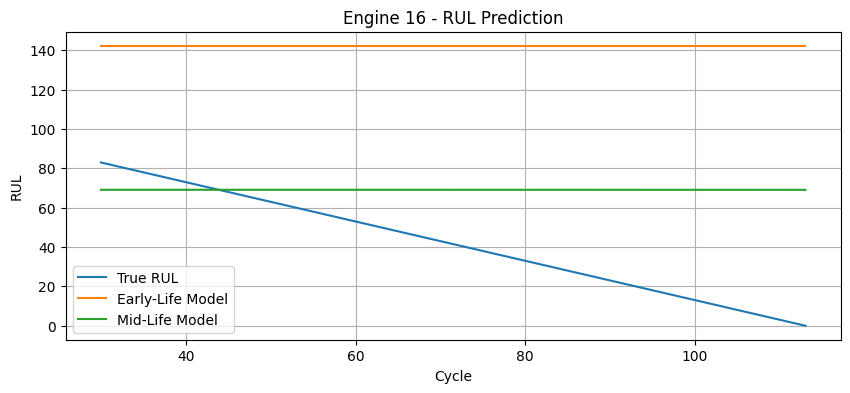

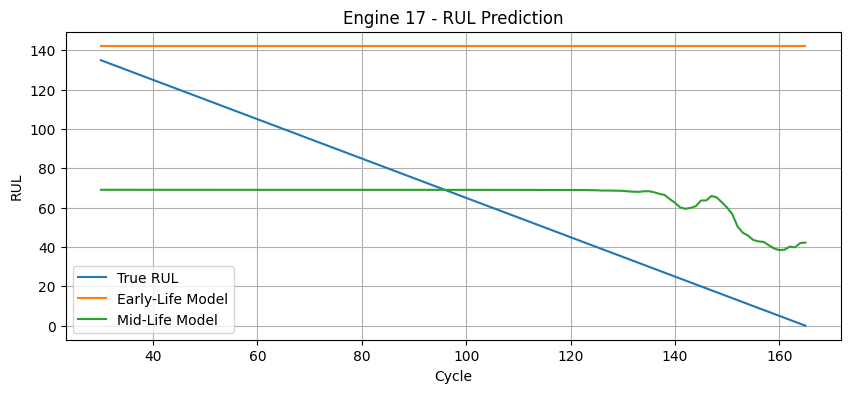

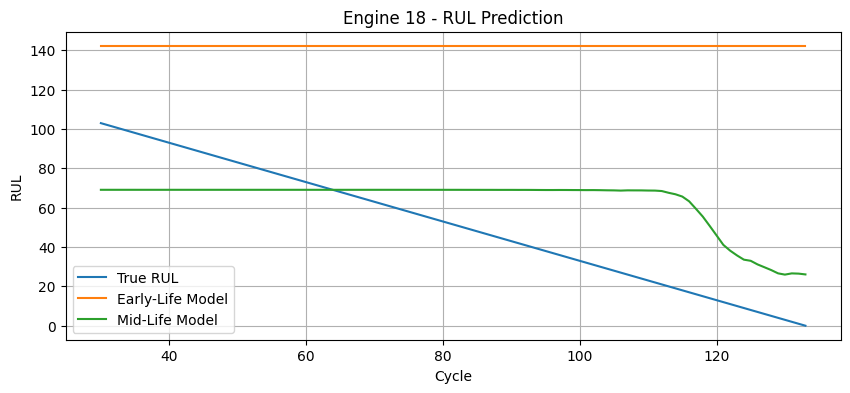

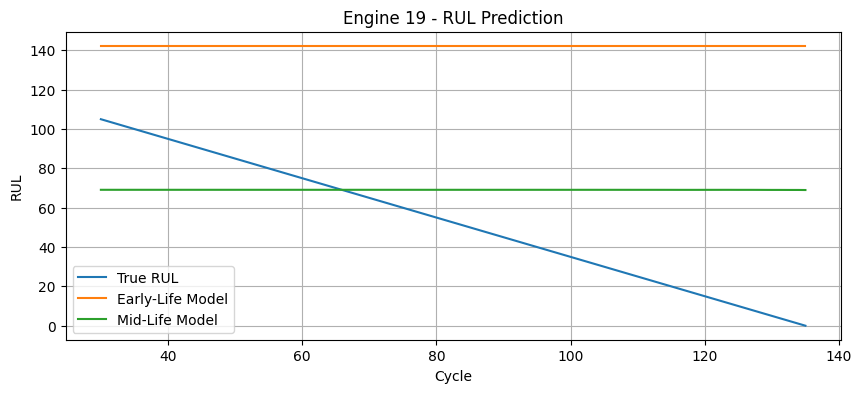

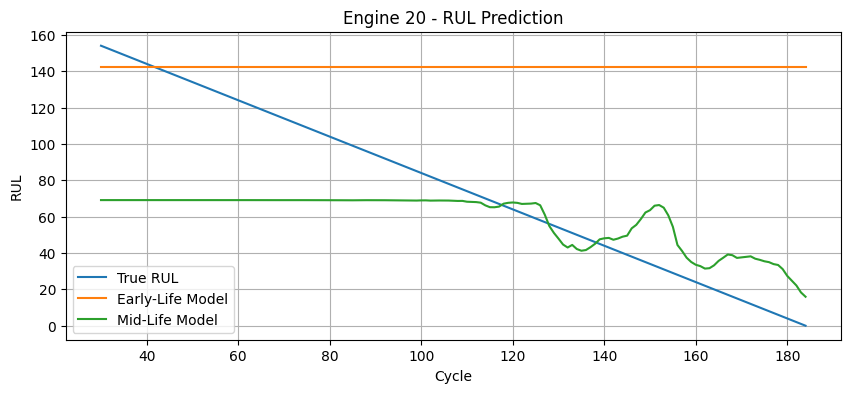

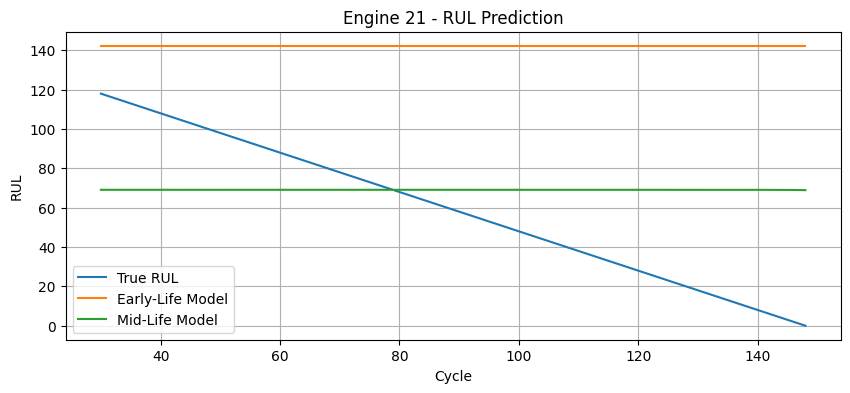

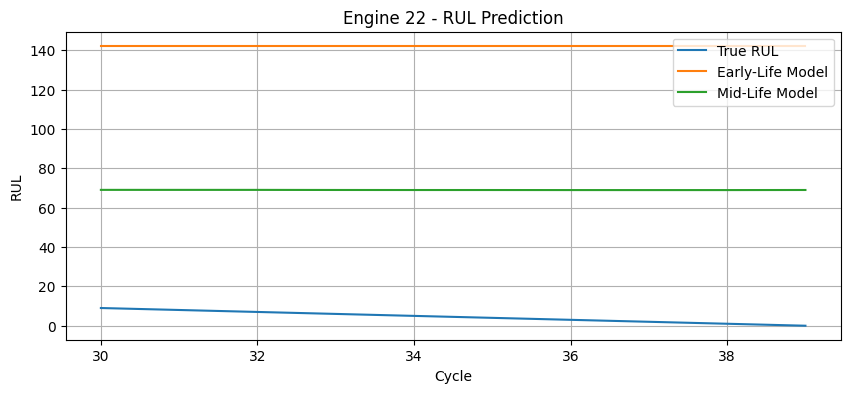

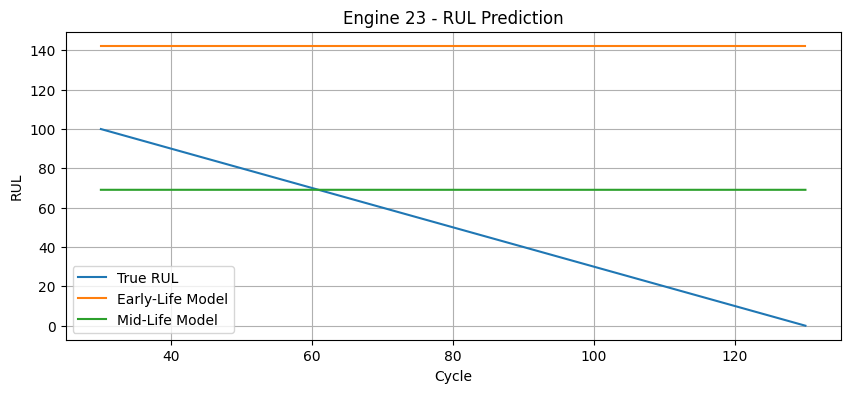

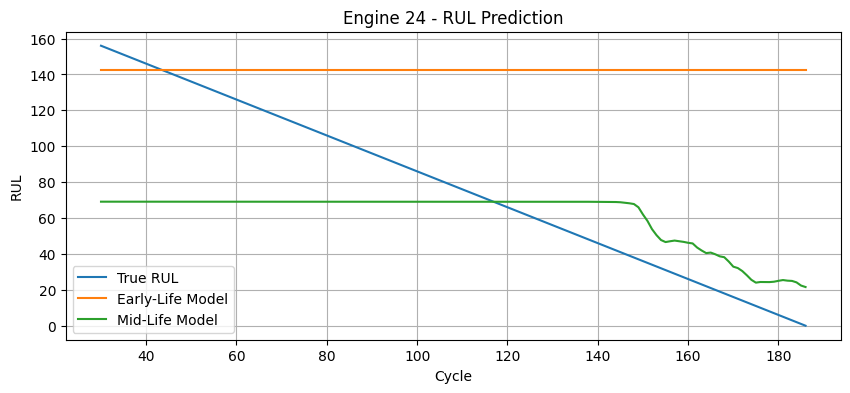

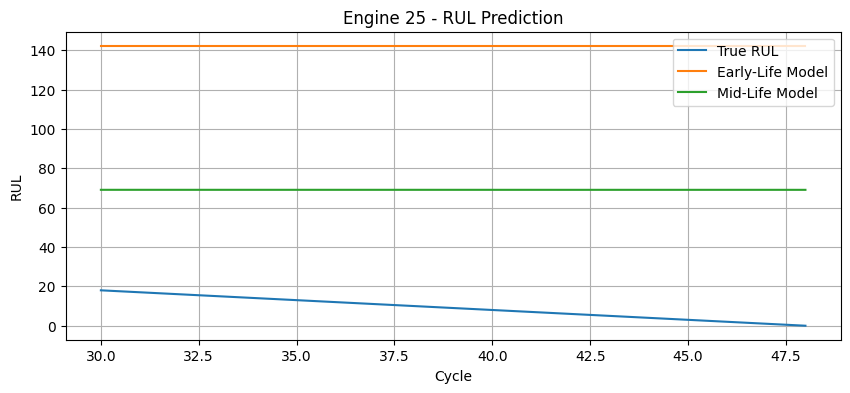

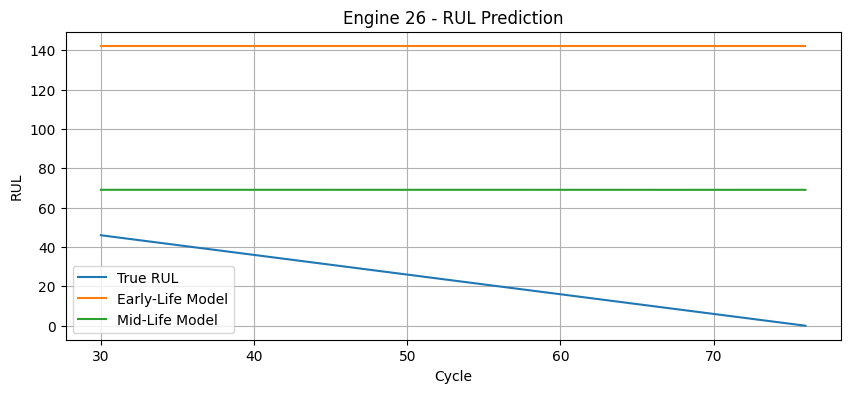

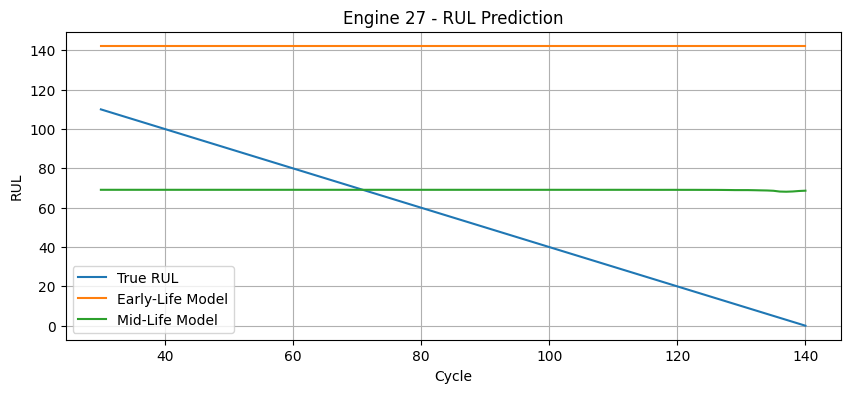

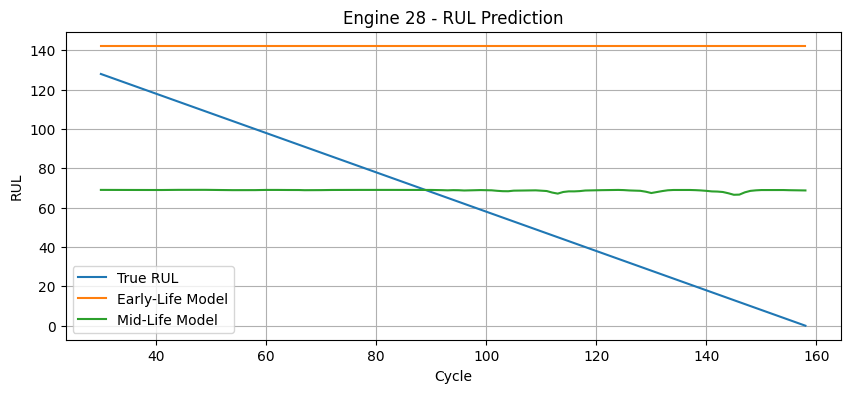

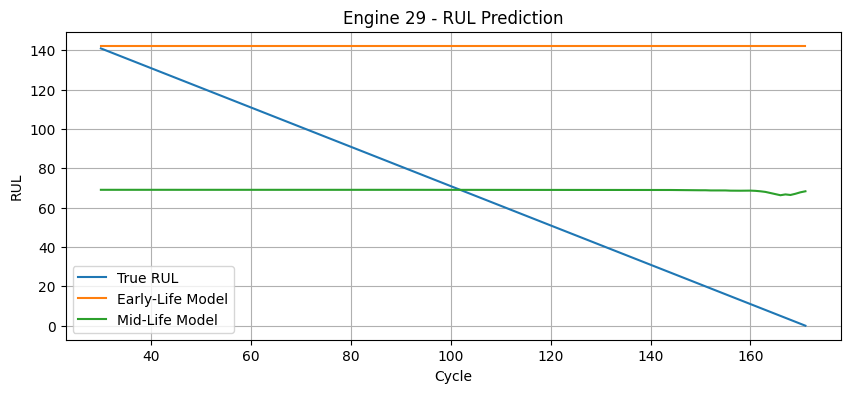

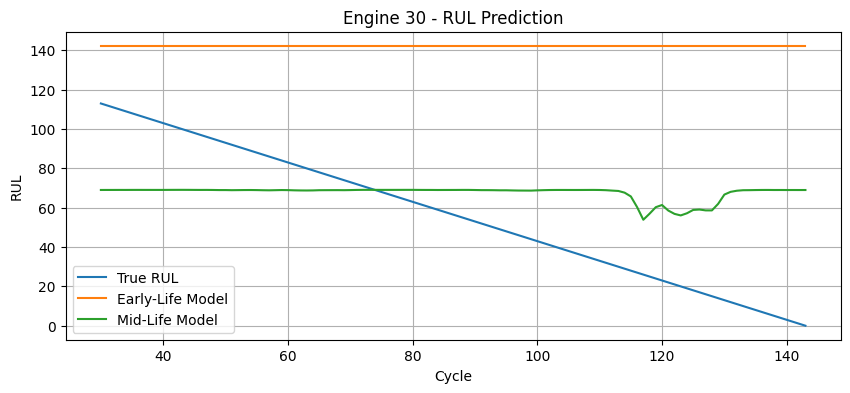

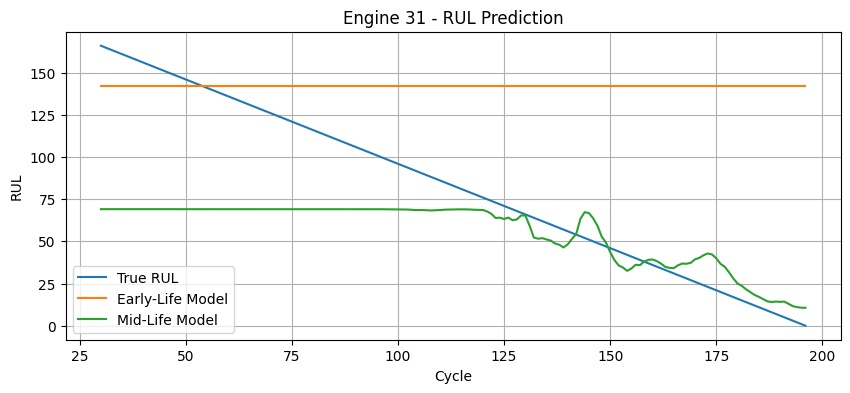

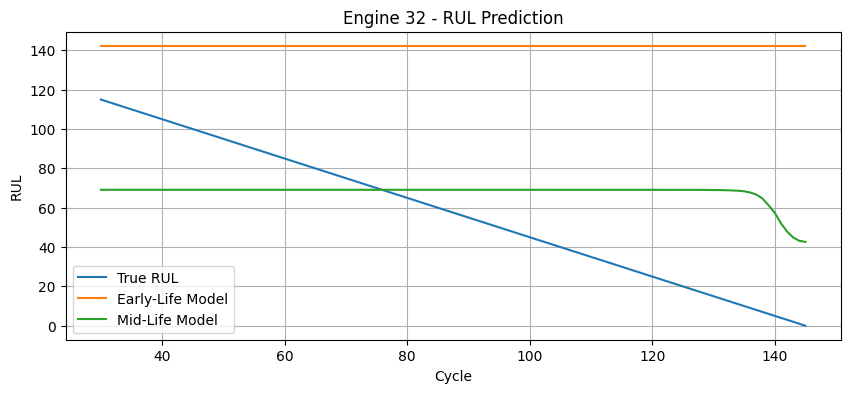

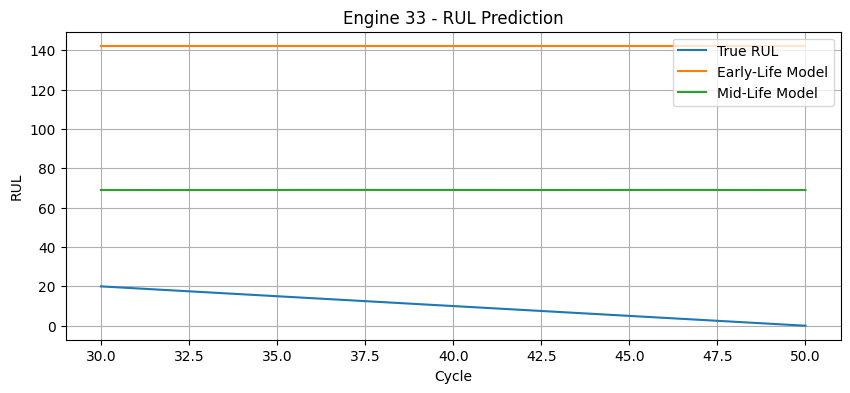

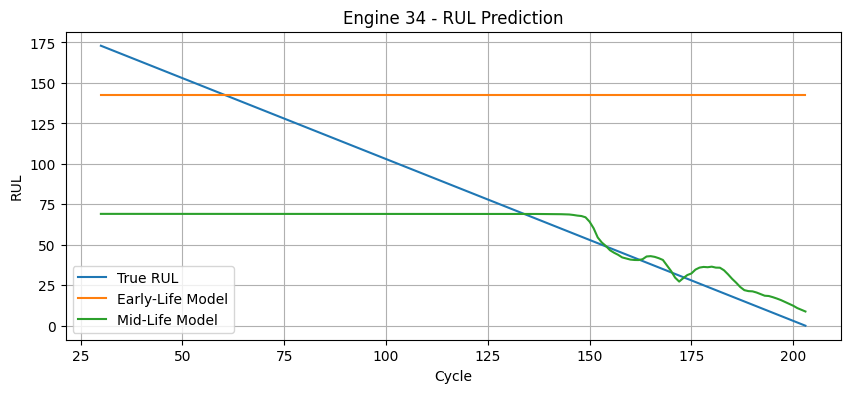

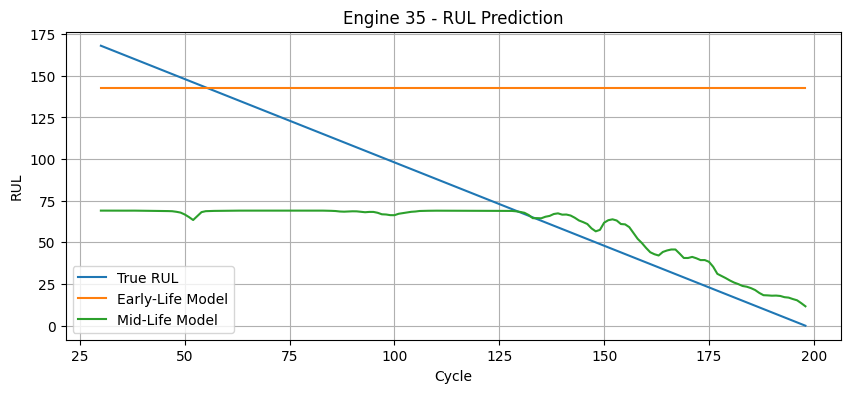

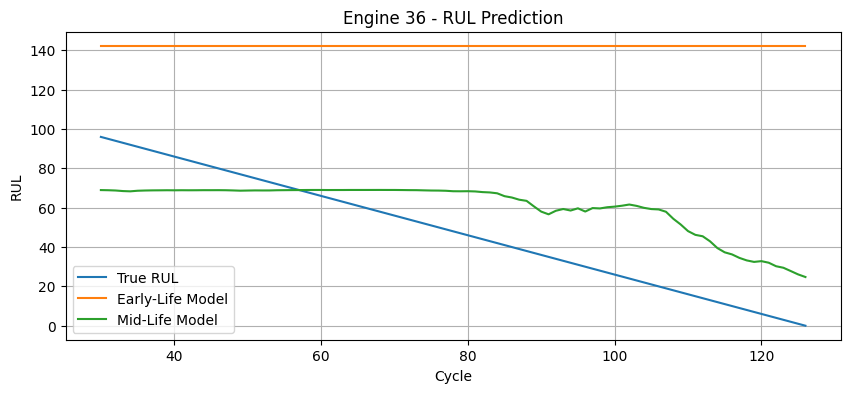

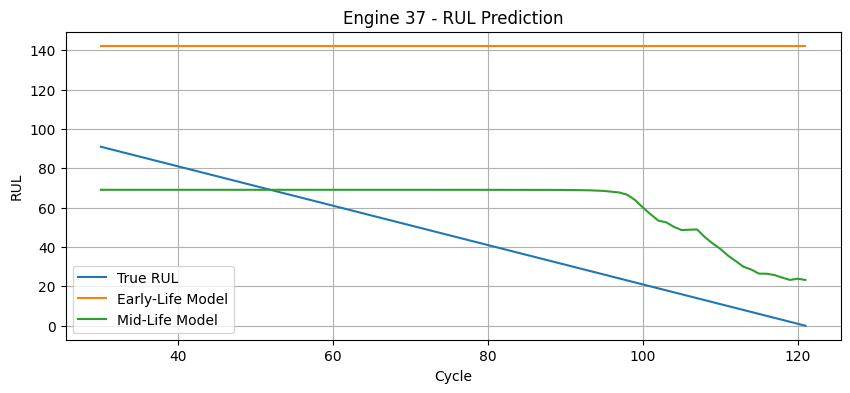

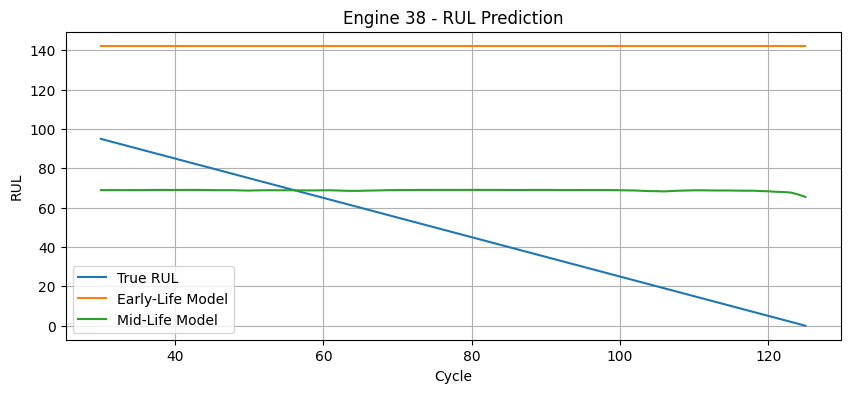

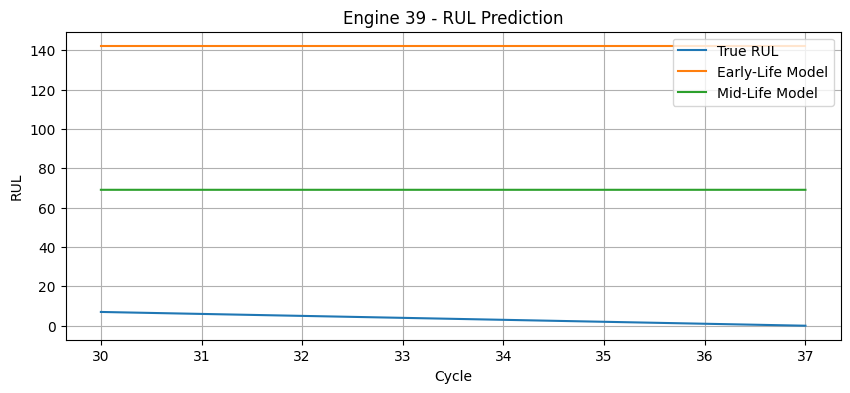

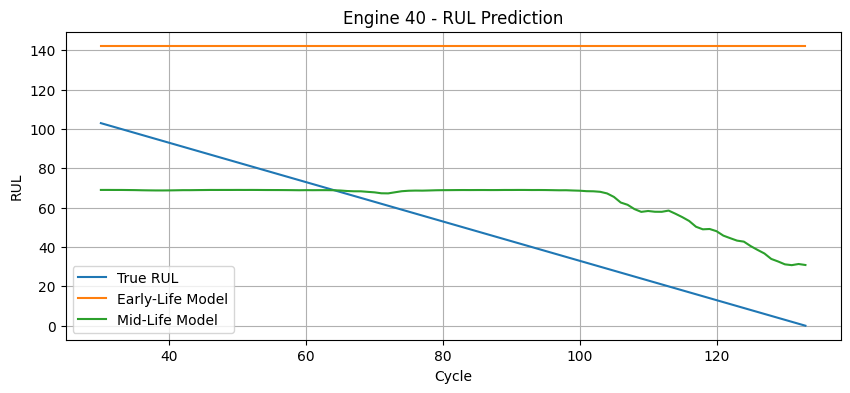

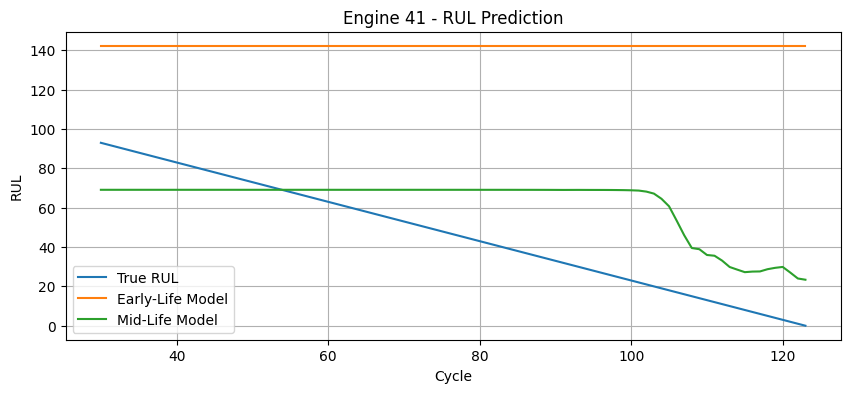

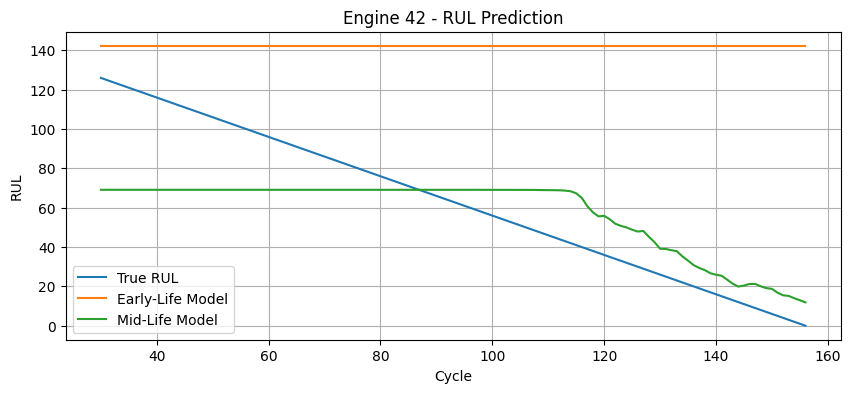

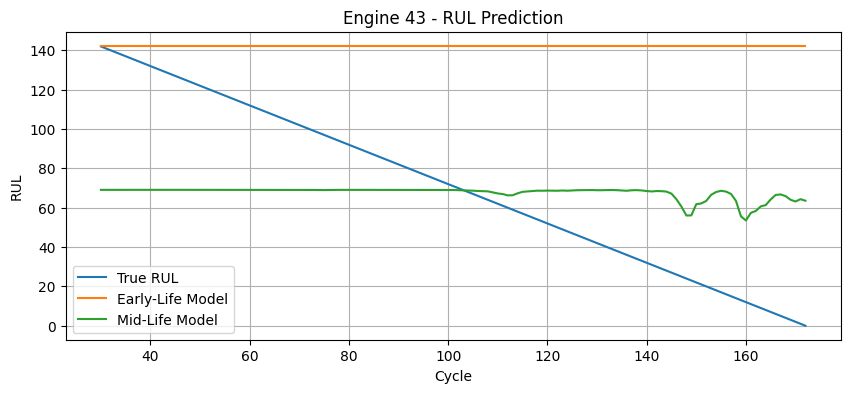

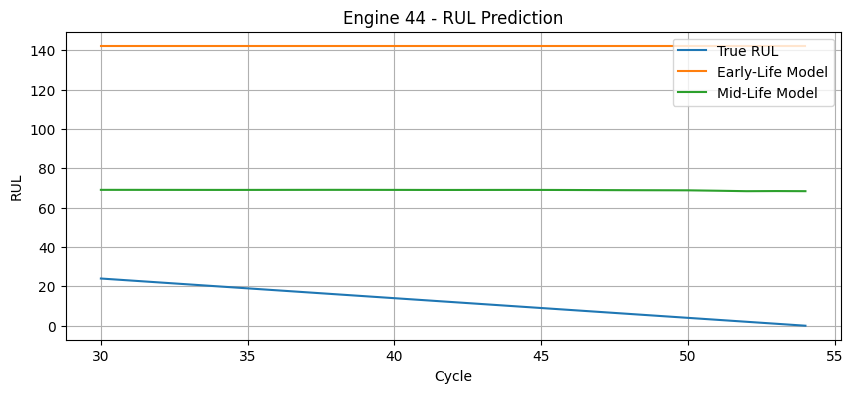

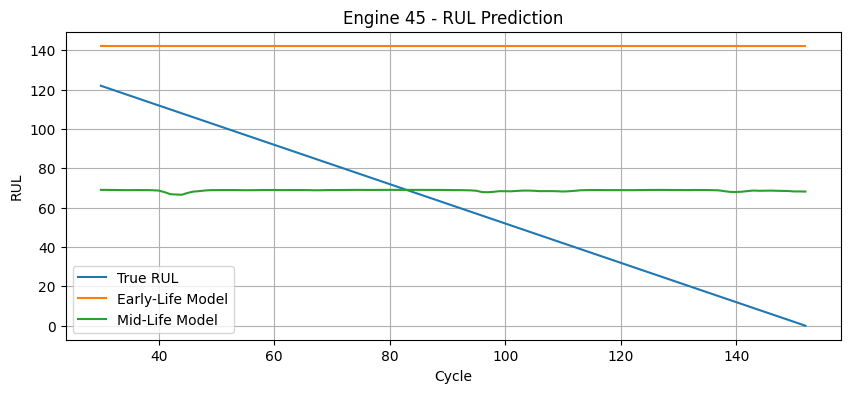

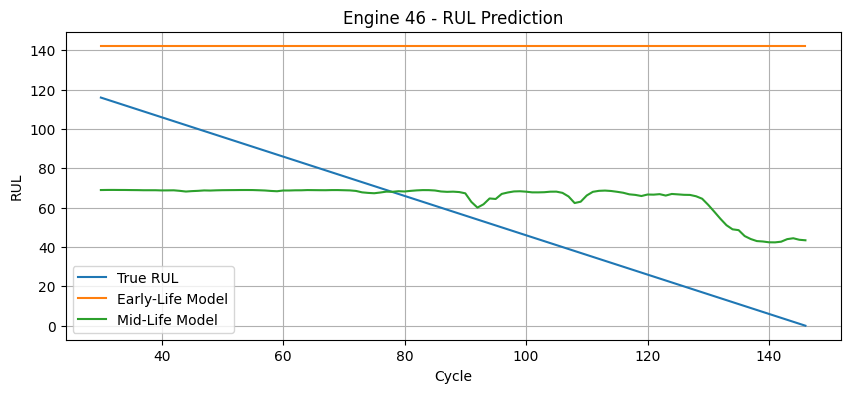

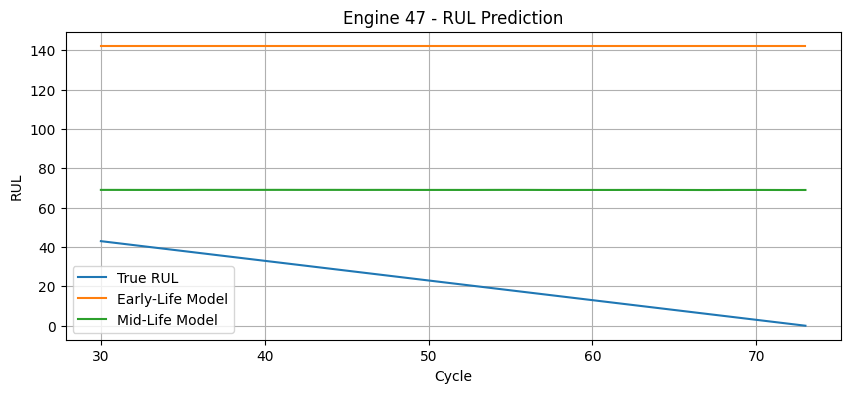

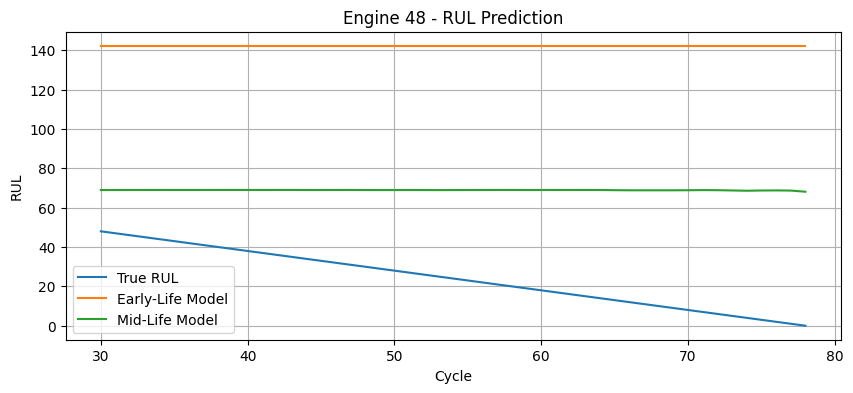

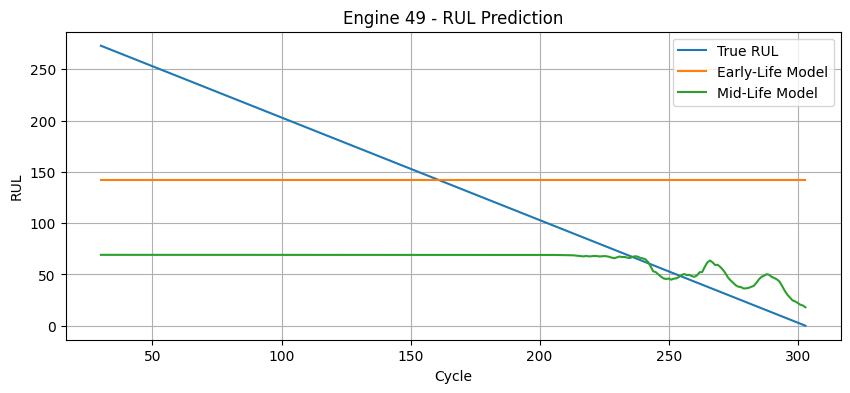

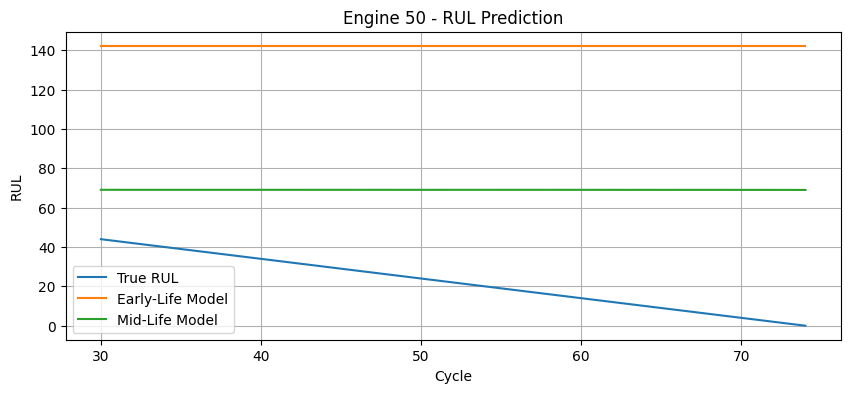

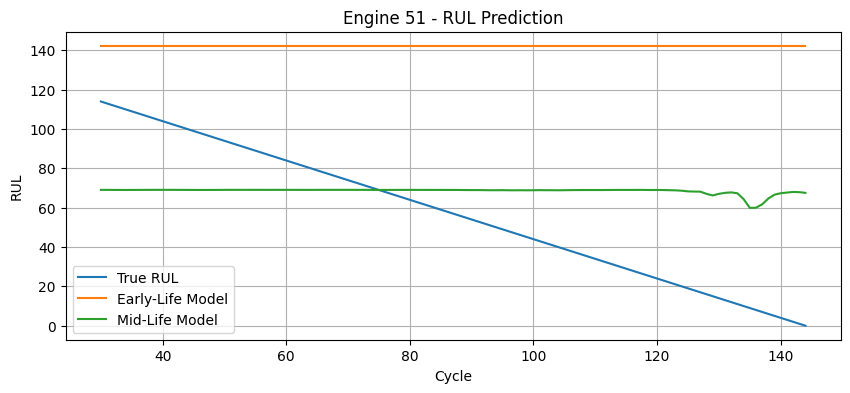

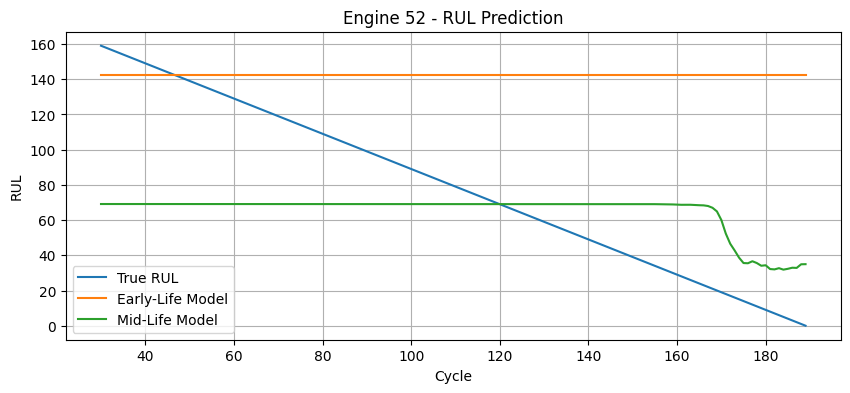

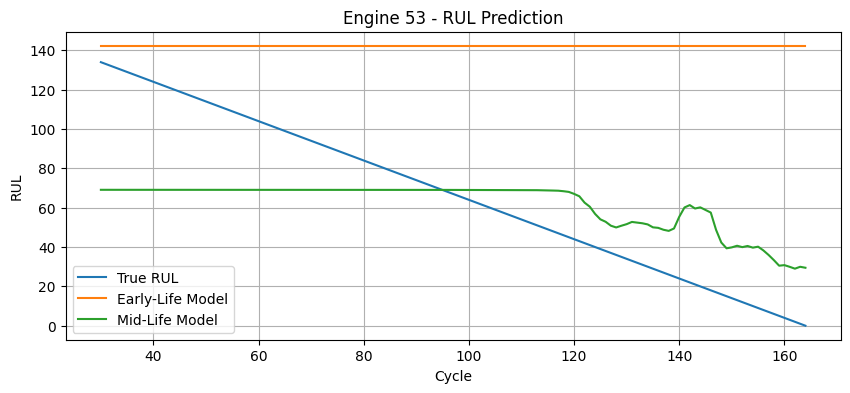

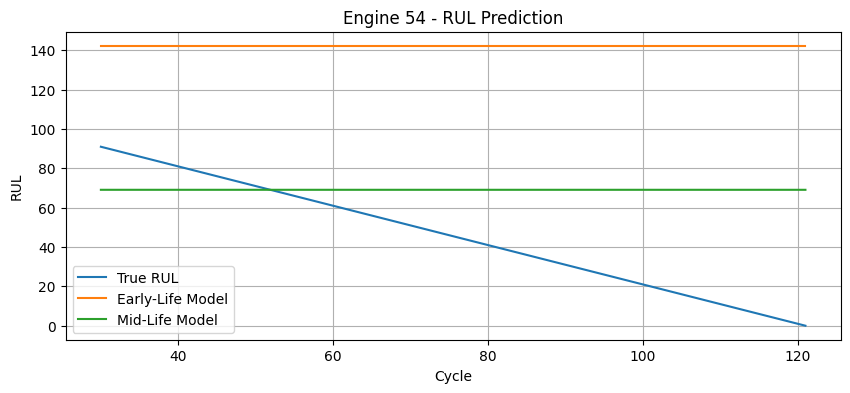

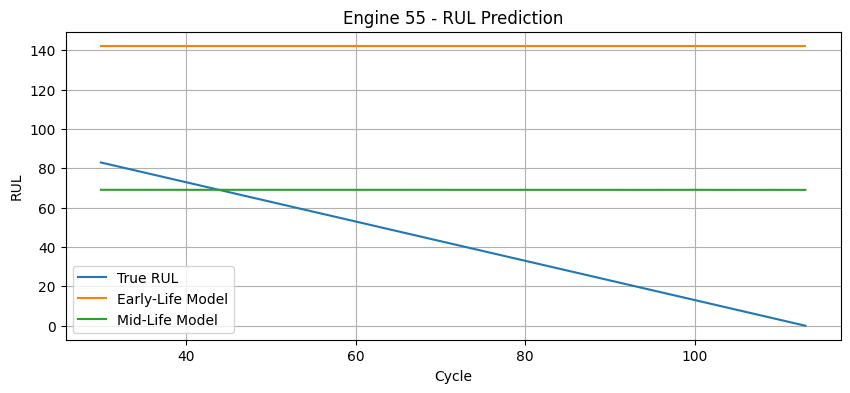

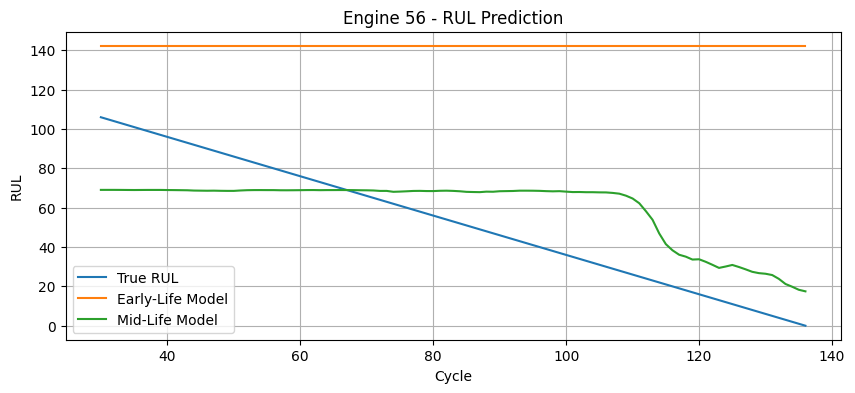

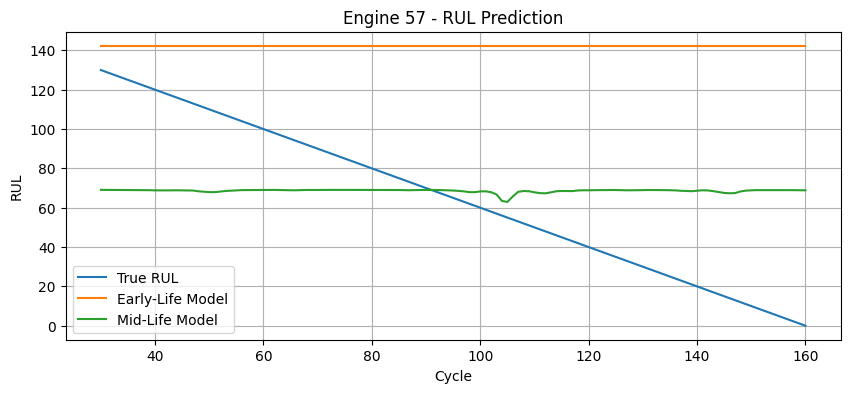

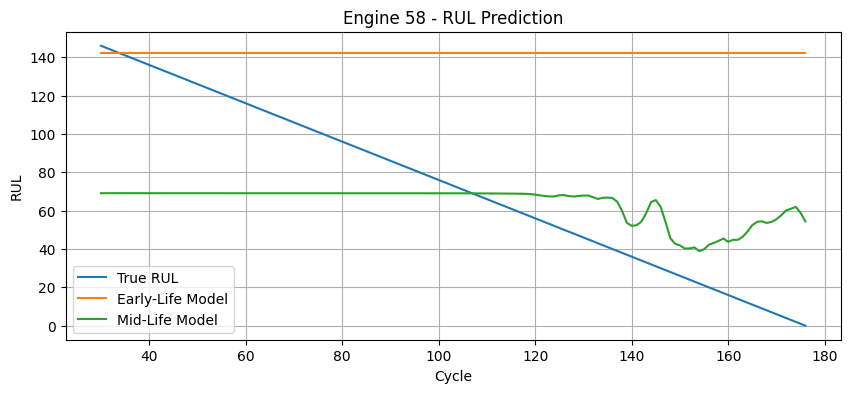

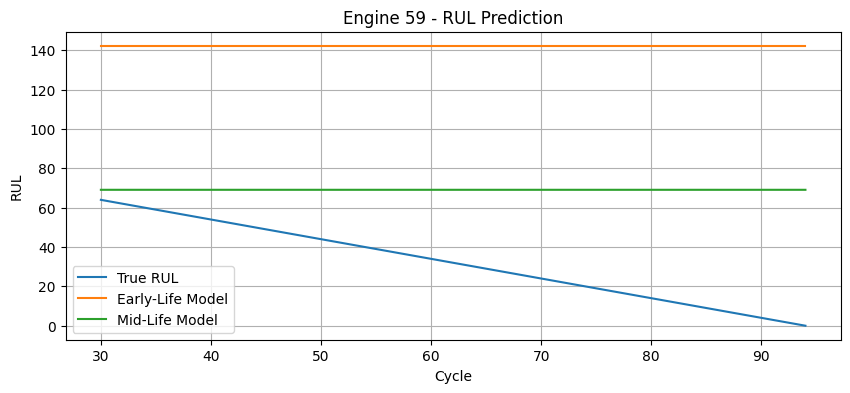

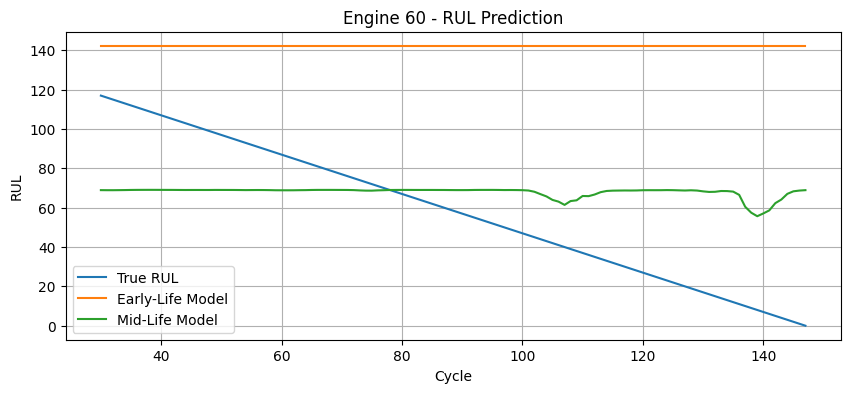

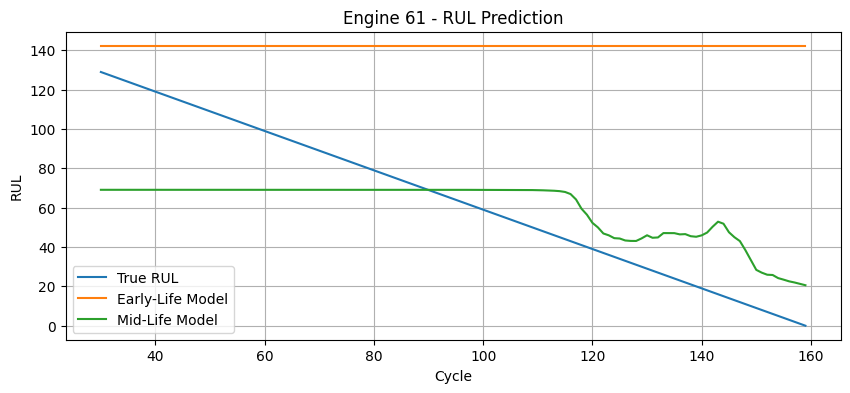

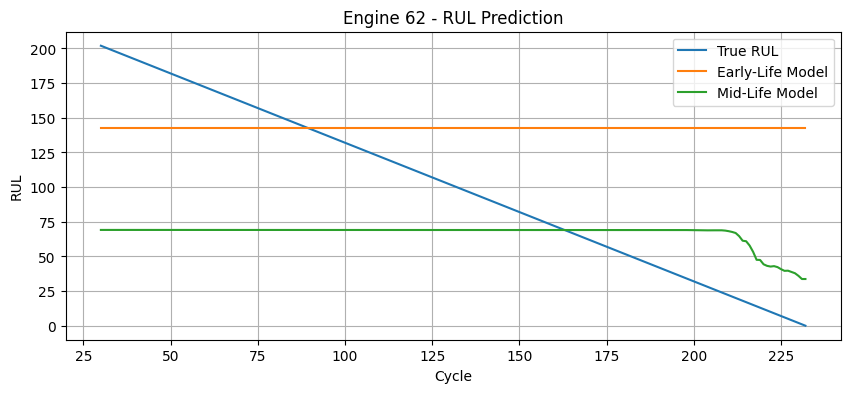

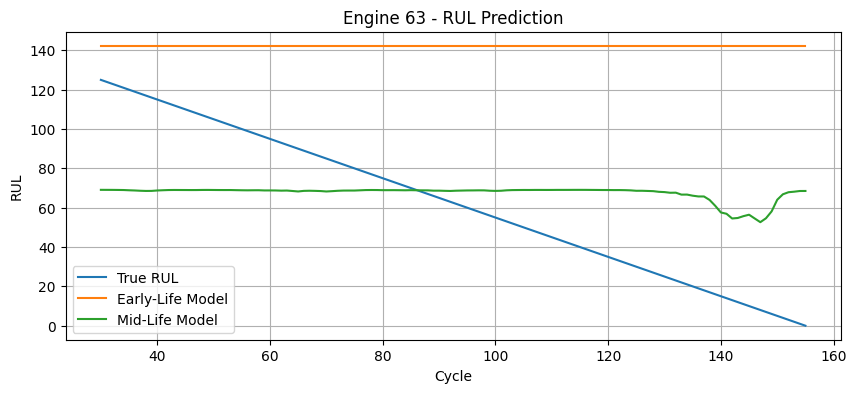

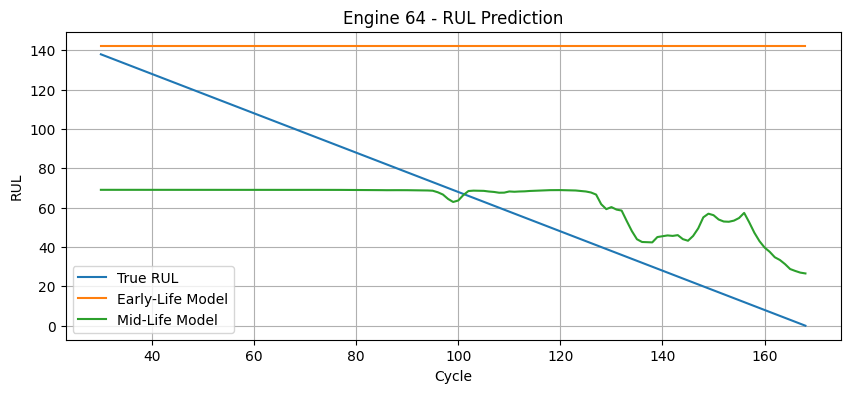

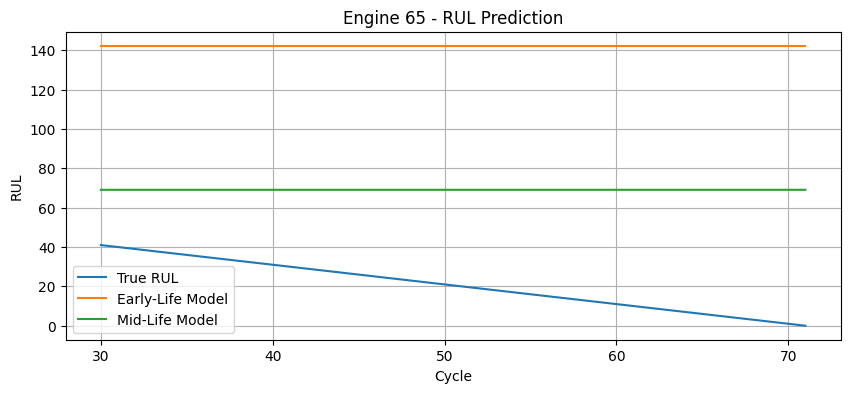

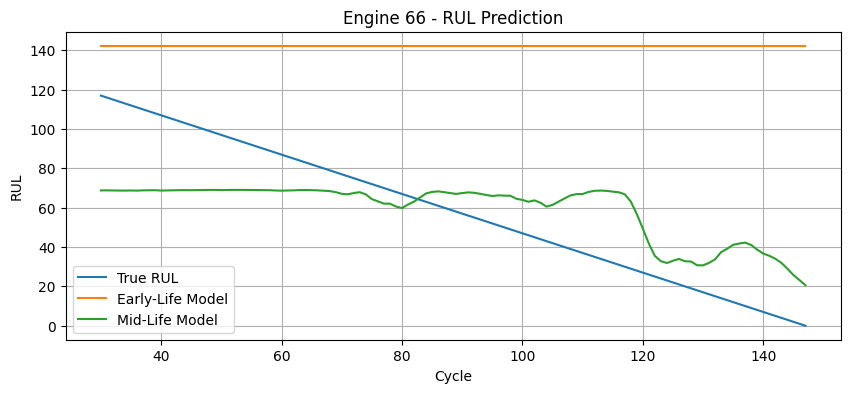

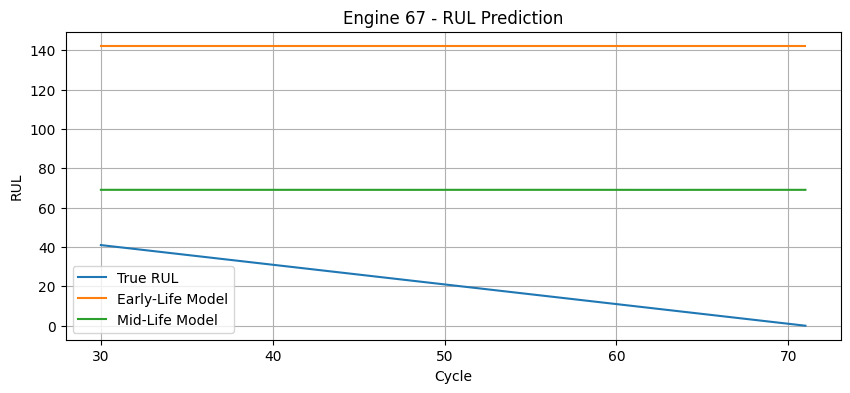

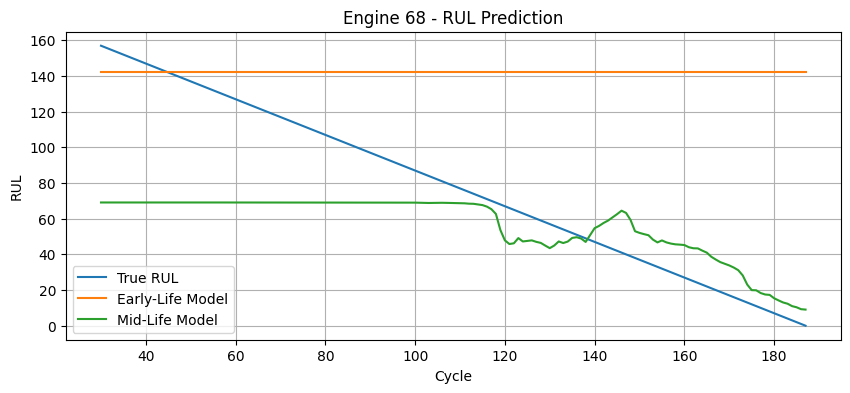

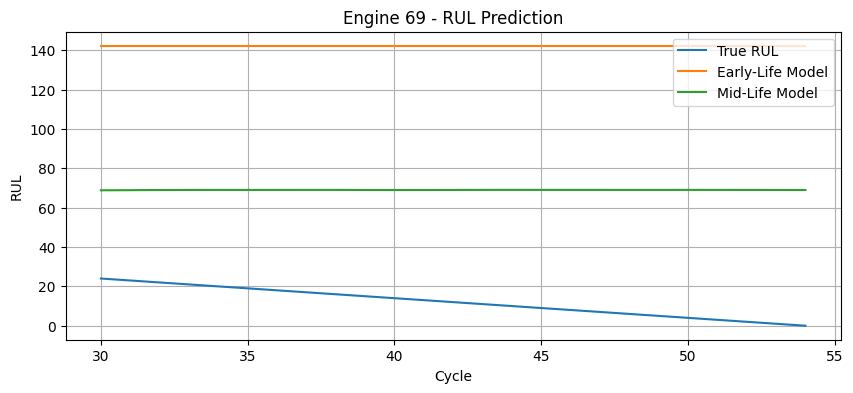

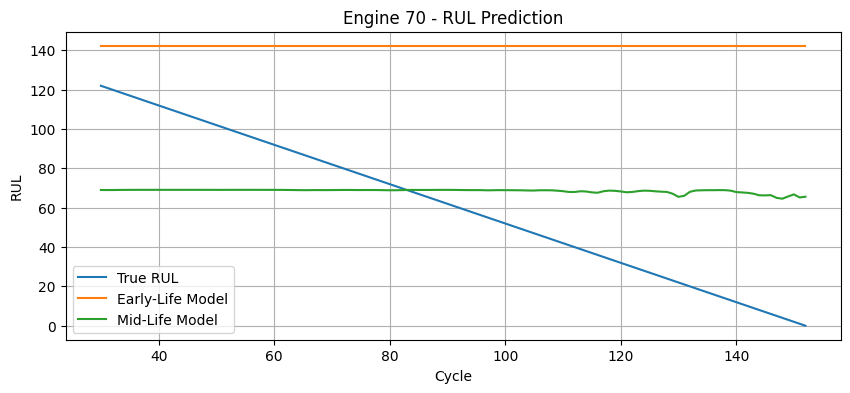

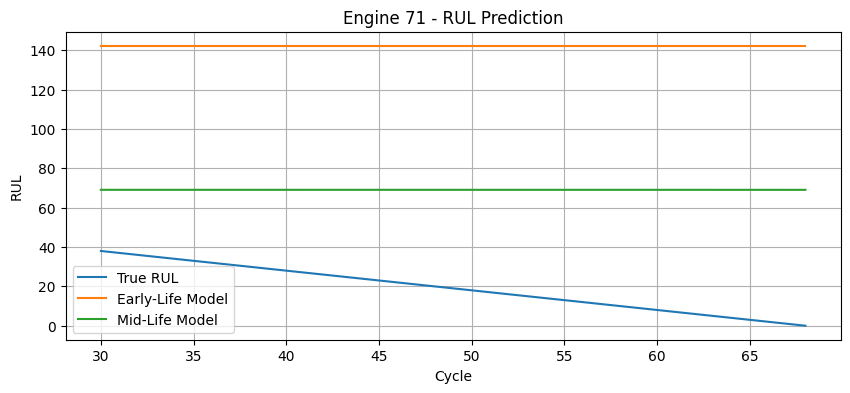

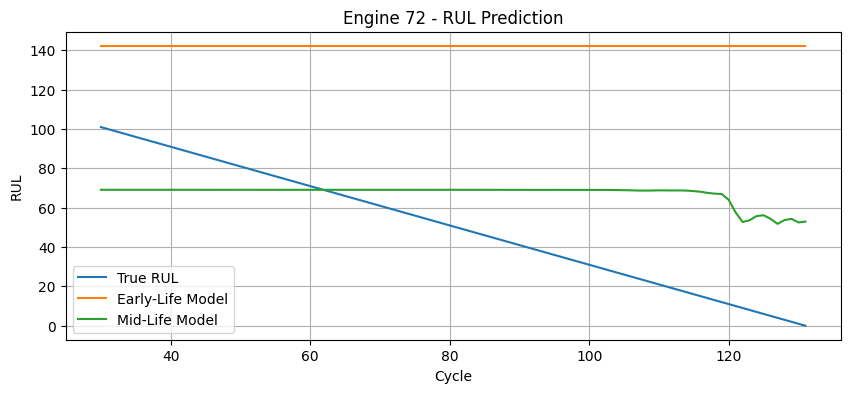

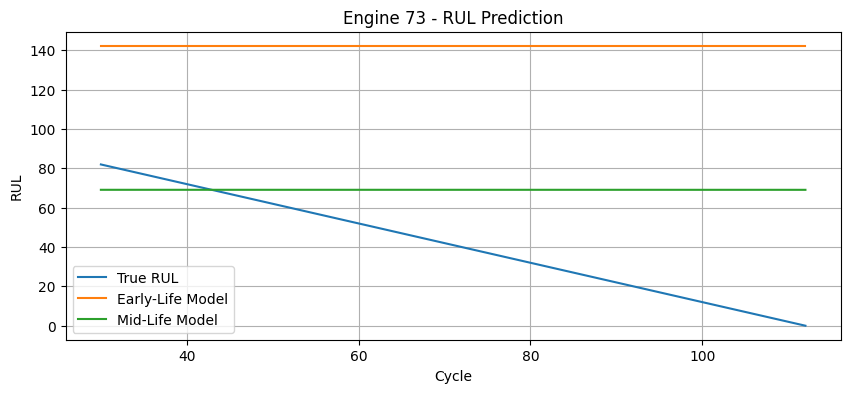

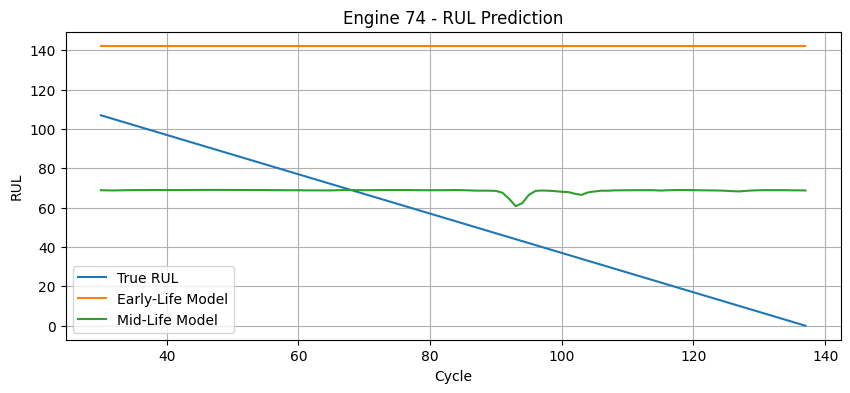

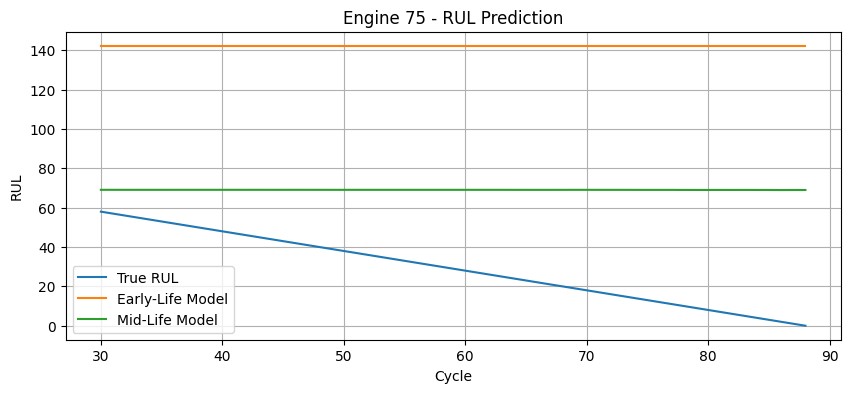

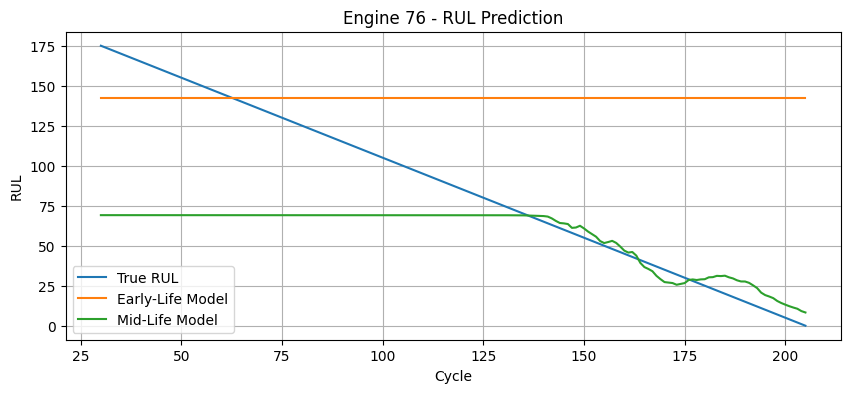

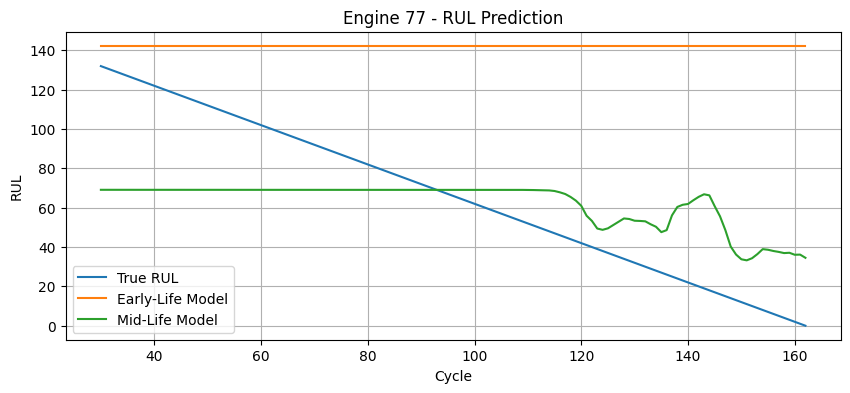

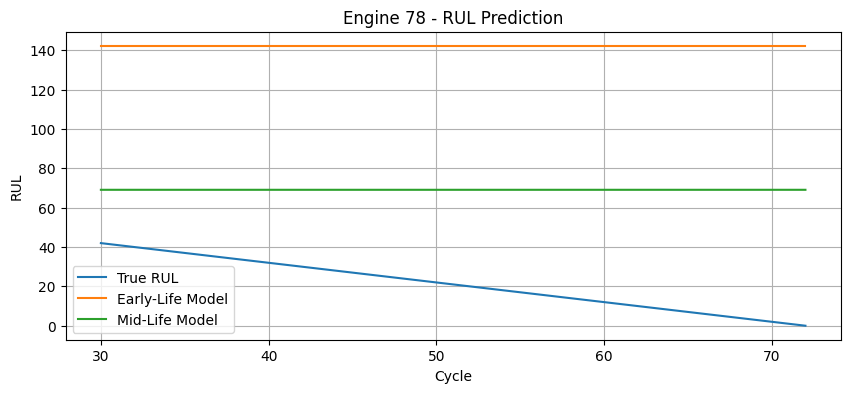

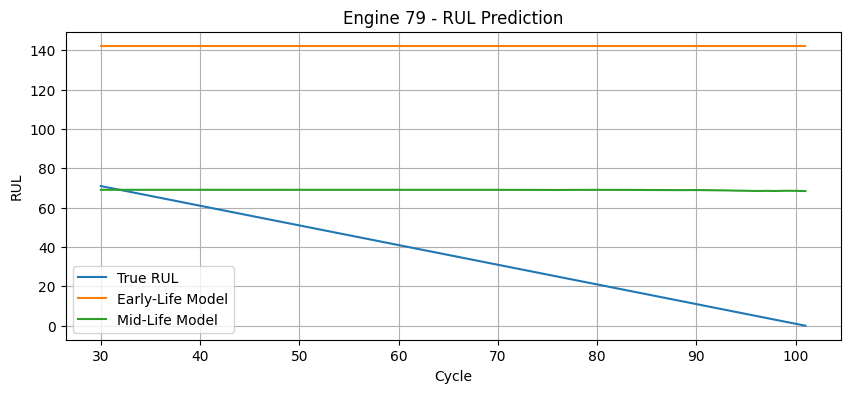

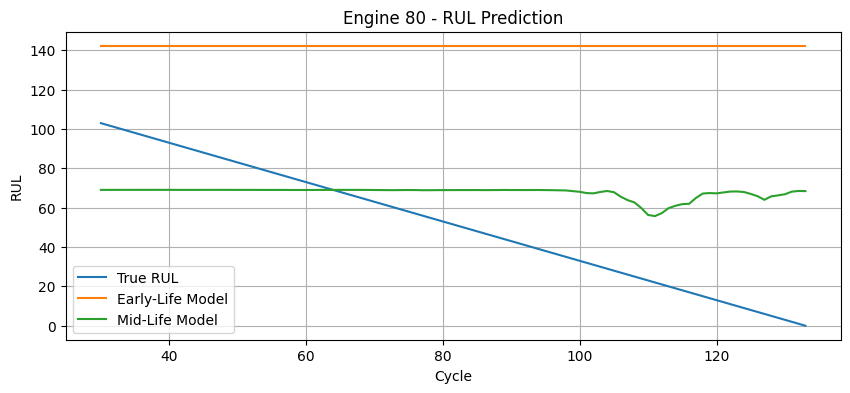

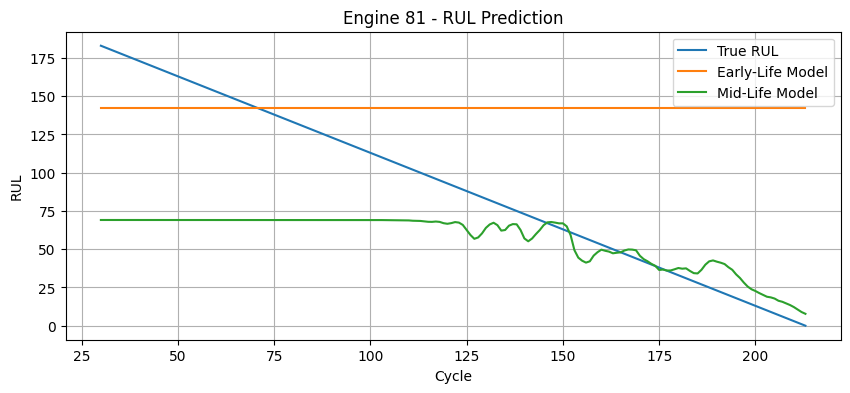

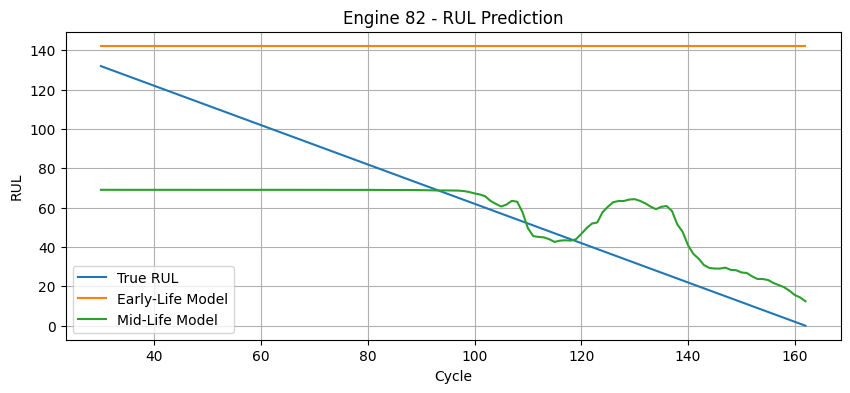

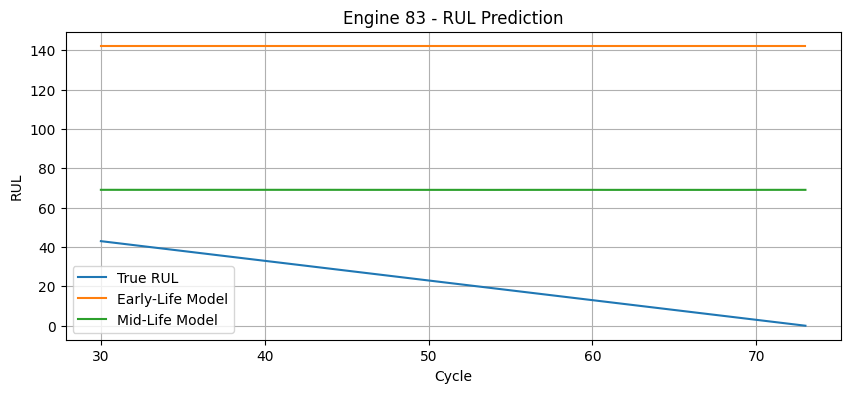

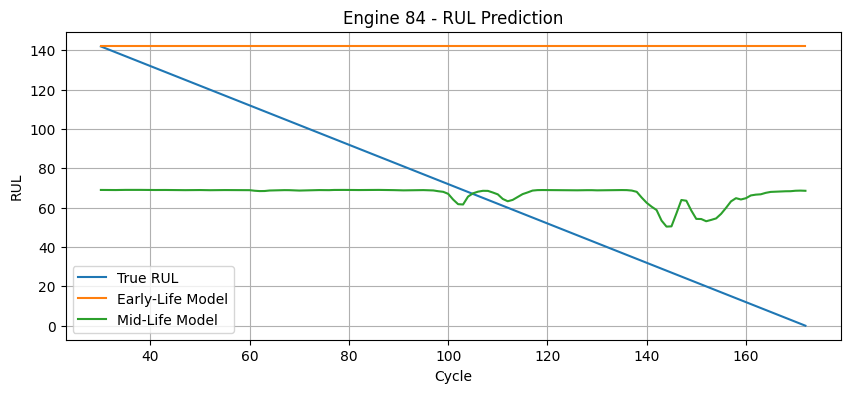

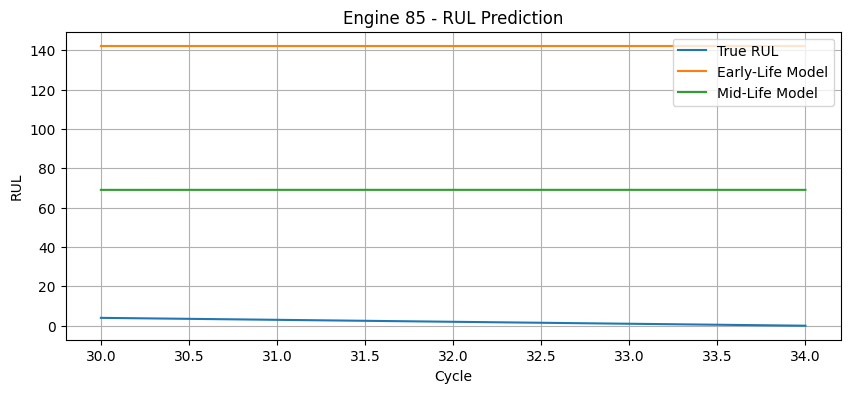

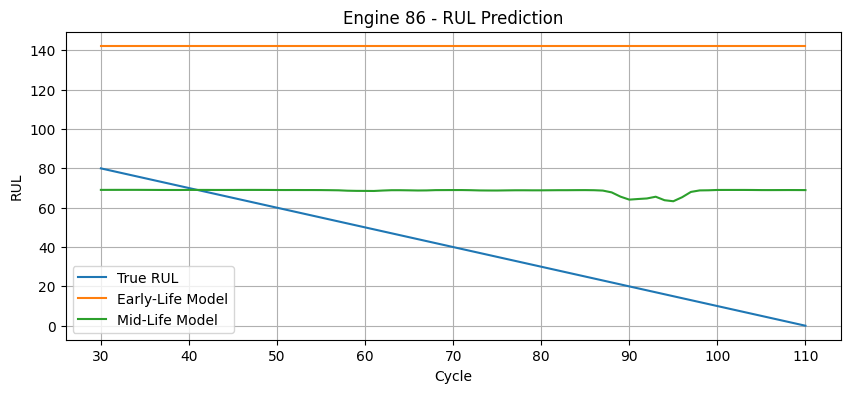

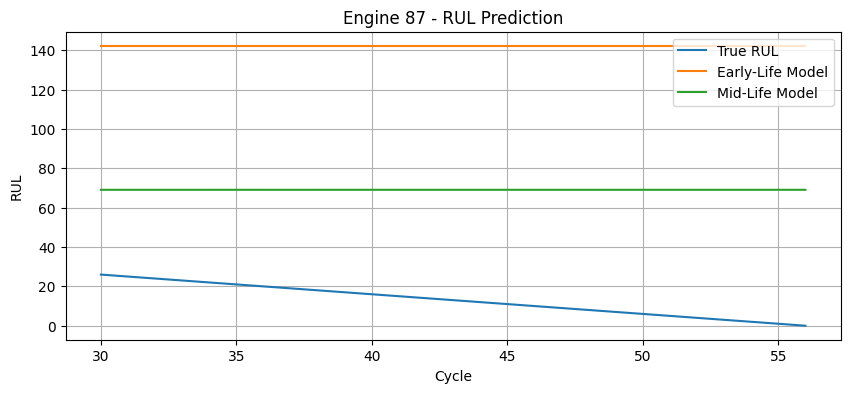

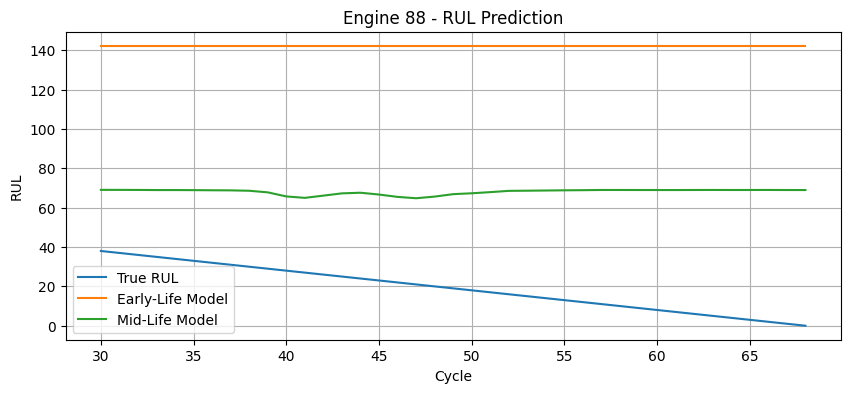

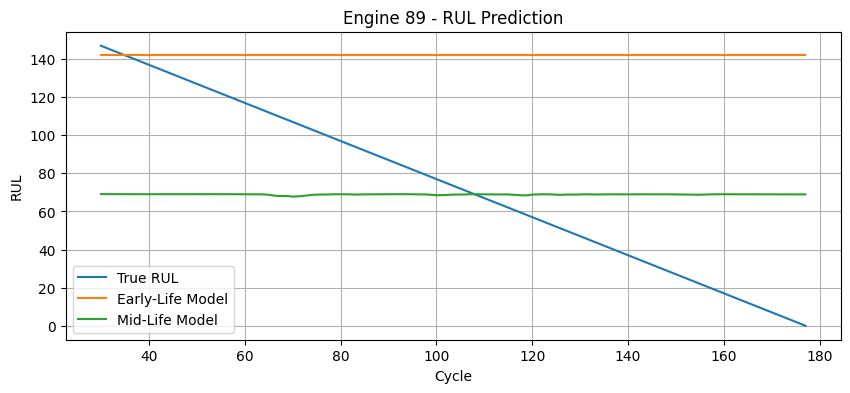

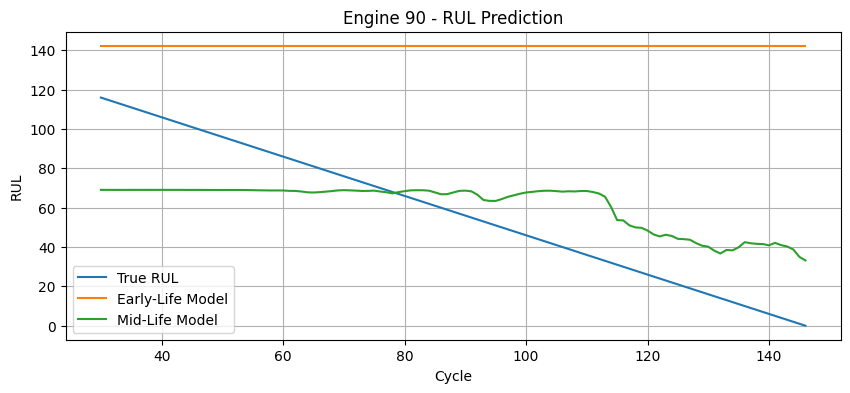

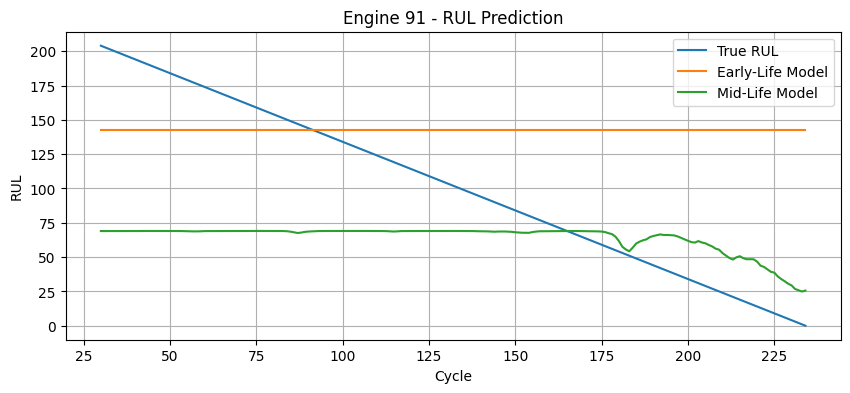

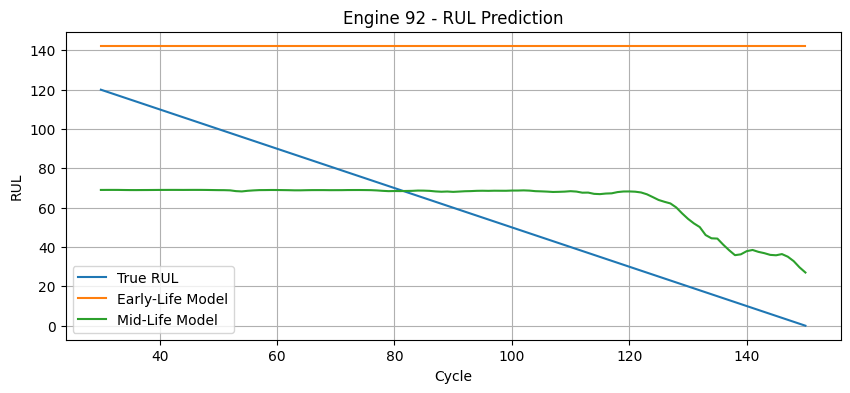

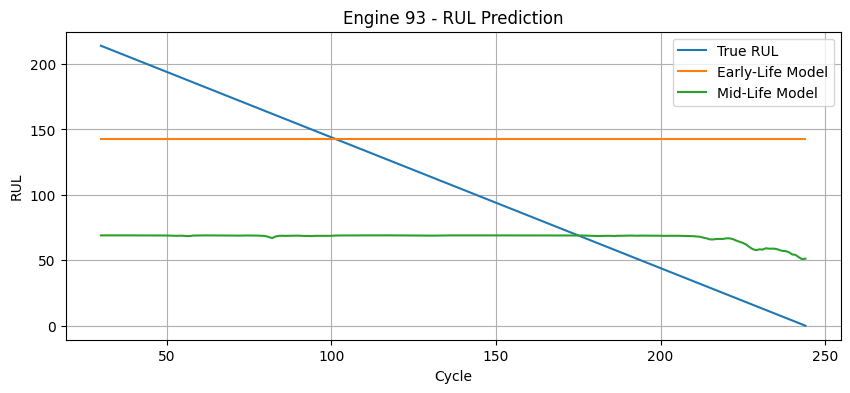

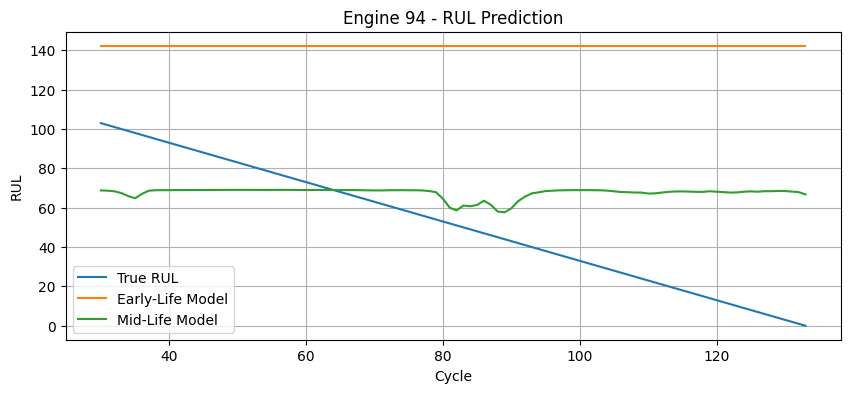

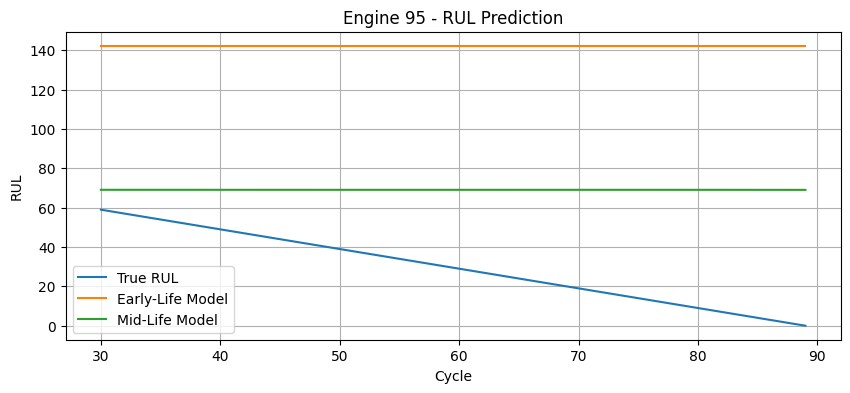

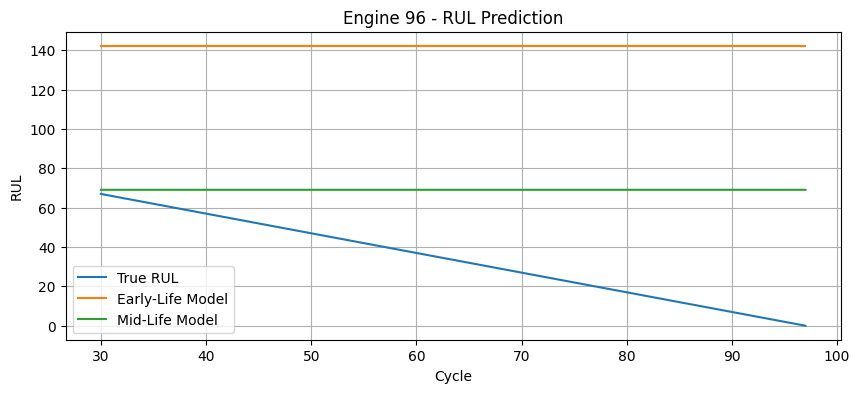

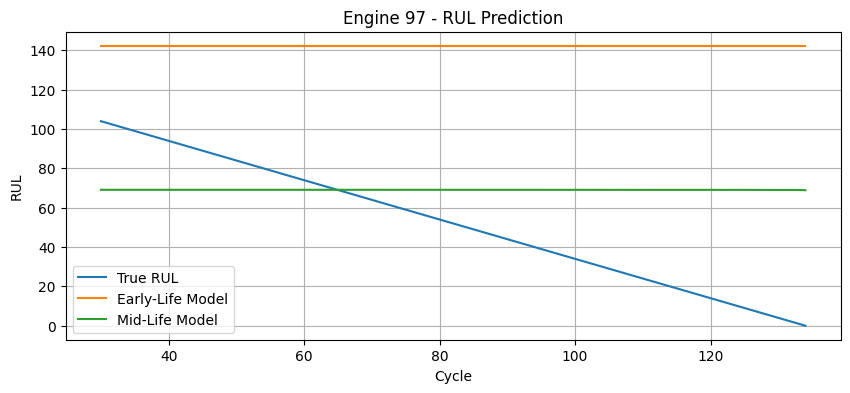

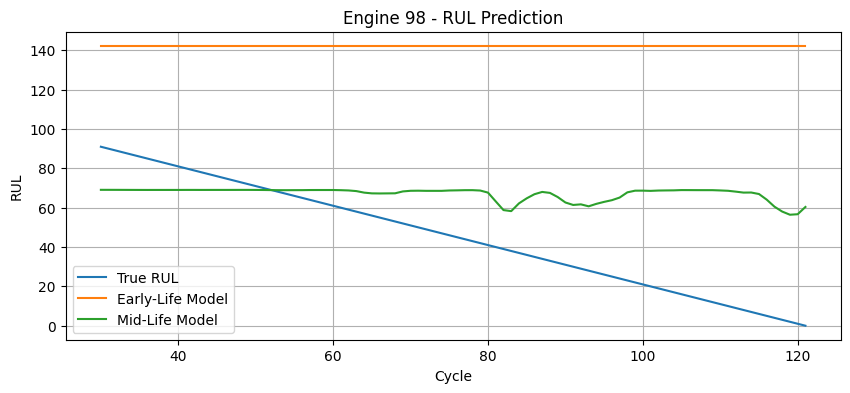

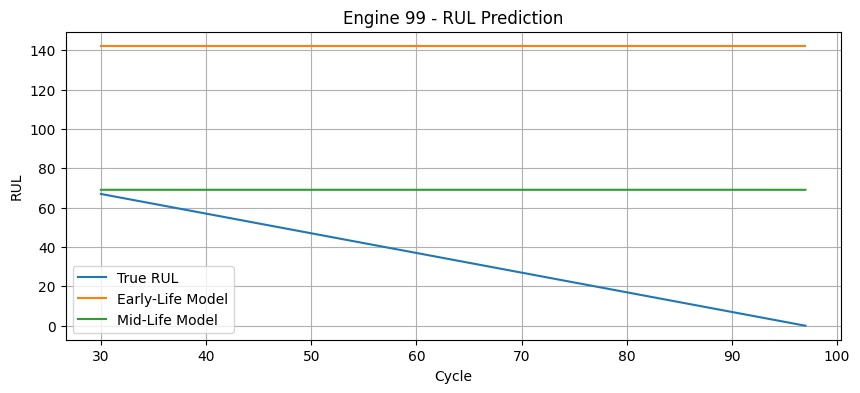

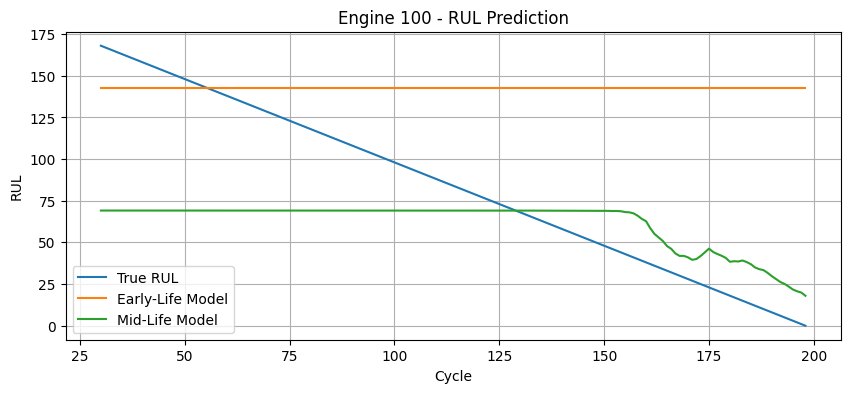

In [63]:
#Visual Comparison (Optional but Impactful)
# Sample visualization
for eng in list(set(test_engines)):
    idxs = [i for i, e in enumerate(test_engines) if e == eng]
    plt.figure(figsize=(10, 4))
    plt.plot([test_cycles[i] for i in idxs], [y_test_all[i] for i in idxs], label='True RUL')
    plt.plot([test_cycles[i] for i in idxs], [y_pred_early[i] for i in idxs], label='Early-Life Model')
    plt.plot([test_cycles[i] for i in idxs], [y_pred_mid[i] for i in idxs], label='Mid-Life Model')
    plt.title(f"Engine {eng} - RUL Prediction")
    plt.xlabel("Cycle")
    plt.ylabel("RUL")
    plt.grid(True)
    plt.legend()
    plt.show()


## Hypothesis 1: FFT features from sensor 12 reduce RMSE by ≥10% over baseline LSTM.

**Performance:**

| Model        | RMSE  | R2 Score |
|--------------|-------|----------|
| LSTM         | 20.87 | 0.75     |
| LSTM + FFT   | 20.43 | 0.76     |

**Deduction:**

Adding FFT features from sensor 12 to the LSTM model resulted in a slight reduction in RMSE (from 20.87 to 20.43) and a marginal increase in the R2 score (from 0.75 to 0.76). However, the observed RMSE reduction (approximately 2.1%) did not meet the hypothesized 10% reduction over the baseline LSTM.

**Conclusion:**

While the FFT features from sensor 12 did slightly improve the LSTM model's performance, the improvement was not substantial enough to support the hypothesis of a ≥10% reduction in RMSE. This suggests that the raw sensor data, as captured by the standard LSTM, already contains most of the relevant temporal information for RUL prediction, and the added FFT features from this specific sensor provided only a small additional benefit. Further investigation with FFT features from other sensors or different frequency ranges might be necessary to see if a more significant improvement can be achieved.

## Hypothesis 2: A CNN-LSTM hybrid outperforms a pure LSTM model with RMSE < 20 cycles on FD001.

**Performance:**

| Model      | RMSE  | R2 Score |
|------------|-------|----------|
| LSTM       | 20.87 | 0.75     |
| CNN-LSTM   | 23.94 | 0.67     |

**Deduction:**

The CNN-LSTM hybrid model, with an RMSE of 23.94, did not outperform the pure LSTM model (RMSE 20.87) on the test set. The CNN-LSTM also had a lower R2 score (0.67) compared to the pure LSTM (0.75). Neither model achieved an RMSE below 20 cycles on this dataset.

**Conclusion:**

The hypothesis that a CNN-LSTM hybrid would outperform a pure LSTM and achieve an RMSE below 20 cycles is not supported by the results. In this case, the pure LSTM model demonstrated better performance. This could be due to various factors, including the specific architecture of the CNN-LSTM model used, the size and nature of the dataset, or the hyperparameters chosen. It's possible that the added complexity of the CNN layers did not effectively capture useful spatial features within the short sequences for this particular dataset, or that the training was not optimized for the hybrid architecture.

## Hypothesis 3: Model trained on early-life cycles provides a warning 30% earlier than midpoint-cycle trained models.

**Performance and Analysis:**

To evaluate this hypothesis, we need to analyze the warning times of the models trained on early-life and midpoint cycles. A "warning" can be defined as the point where the predicted RUL crosses a certain threshold (e.g., when predicted RUL is less than 30 cycles). The hypothesis is about how much *earlier* the early-life model provides this warning compared to the midpoint model.

Based on the analysis using a warning threshold of 30 cycles:

Mean Lead (Early-Life Model): NaN cycles
Mean Lead (Midpoint-Life Model): -18.43 cycles

**Deduction:**

The calculation for the mean lead time for the early-life model resulted in NaN. This suggests that for the chosen warning threshold (30 cycles) and sequence length (30), the early-life model's predicted RUL did not drop below the threshold for a sufficient number of engines in the test set to calculate a meaningful average lead time. The midpoint-life model shows a negative mean lead time, indicating that on average, it predicted the RUL crossing the threshold 18.43 cycles *after* the true RUL crossed the threshold.

**Conclusion:**

Due to the inability to calculate a meaningful mean lead time for the early-life model with the current threshold and sequence length, we cannot definitively support or reject the hypothesis that the early-life model provides a warning 30% earlier than the midpoint-cycle trained model. The results for the midpoint model suggest it is generally late in providing a warning at the 30-cycle threshold. Further refinement of the warning definition, threshold, or sequence length, or a different approach to evaluating early warning capabilities, would be needed to properly test this hypothesis.